<div style="position:relative; width:100%;">
  <!-- Logo absoluto en la esquina superior derecha (encima del título) -->
  <img src="../assets/OsGeolab.png"
       alt="Logo semillero"
       style="position:absolute; top:0; right:0; width:200px; z-index:50; pointer-events:none;">
    <img src="../assets/Ud.png"
       alt="Logo ud"
       style="position:absolute; top:0; left:0; width:100px; z-index:50; pointer-events:none;">
  <!-- Título centrado; le damos padding-top para que el logo pueda quedar encima -->
  <h2 style="text-align:center; margin:0; padding-top:100px;">
    Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.
  </h2>
</div>

<h2 style="text-align:center;" >Tutorial: Uso de prompts de tipo texto en la segmentación</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

In [2]:
# Instalar dependencias necesarias para LangSAM
!pip install groundingdino-py --upgrade
!pip install segment-geospatial --upgrade
!pip install transformers --upgrade

In [3]:
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from samgeo.text_sam import LangSAM
import matplotlib.pyplot as plt
import cv2
import torch

# Verificar que CUDA esté disponible
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Versión de PyTorch: {torch.__version__}")

CUDA disponible: True
Versión de PyTorch: 2.7.1+cu118


In [4]:
sam = LangSAM(model_type="vit_h")

final text_encoder_type: bert-base-uncased


In [5]:
# GPU and batch helpers: clear GPU and robust box processing
import gc

def clear_gpu_memory():
    """Limpia la memoria GPU/CPU para reducir OOMs."""
    import torch
    import gc
    if torch.cuda.is_available():
        try:
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        except Exception:
            pass
    gc.collect()


def process_boxes_in_batches(sam_instance, image_path, boxes_array, batch_size=1):
    """
    Procesa cajas una a una (o en pequeños lotes) usando el predictor de SAM.
    Devuelve una lista de máscaras numpy uint8 (0/255).

    Esta versión está instrumentada con prints diagnósticos para detectar
    si las máscaras devueltas por SAM son torch.Tensor u otro tipo.
    """
    import cv2
    import numpy as np
    import torch
    import gc

    all_masks = []

    # Cargar imagen (BGR) y convertir a RGB HWC
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error: no se pudo cargar la imagen: {image_path}")
        return []
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Intentar set_image en el predictor SAM
    try:
        if hasattr(sam_instance, 'sam') and hasattr(sam_instance.sam, 'set_image'):
            sam_instance.sam.set_image(image_rgb)
        elif hasattr(sam_instance, 'set_image'):
            sam_instance.set_image(image_rgb)
    except Exception as e:
        print(f"⚠️ Warning set_image falló: {e}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    total = len(boxes_array)
    for idx, box in enumerate(boxes_array):
        print(f"   📦 Procesando caja {idx+1}-{total}")
        try:
            # Liberar memoria pequeña antes
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Asegurar que la caja sea numpy float y forma (1,4)
            box_np = np.asarray(box, dtype=float).reshape(1, 4)
            box_tensor = torch.tensor(box_np, dtype=torch.float32, device=device)

            # Llamada al predictor; diferentes versiones aceptan distintos argumentos
            try:
                masks_out = sam_instance.sam.predict(
                    point_coords=None,
                    point_labels=None,
                    box=box_tensor,
                    multimask_output=False,
                )
            except TypeError:
                # Fallback si la firma es distinta
                masks_out = sam_instance.sam.predict(box=box_tensor, multimask_output=False)

            # DEBUG: tipo de retorno bruto
            try:
                print(f"     ▶ masks_out type: {type(masks_out)}")
            except Exception:
                pass

            # masks_out puede ser (masks, scores, logits) o directamente masks
            if isinstance(masks_out, tuple) and len(masks_out) >= 1:
                masks = masks_out[0]
            else:
                masks = masks_out

            try:
                print(f"     ▶ masks resolved to: {type(masks)}")
            except Exception:
                pass

            # Normalizar cada máscara a numpy uint8 0/255
            for m_i, m in enumerate(masks):
                # DEBUG: mostrar tipo/shape inicial
                try:
                    print(f"       · mask[{m_i}] tipo: {type(m)}")
                    if hasattr(m, 'shape'):
                        try:
                            print(f"         shape: {getattr(m, 'shape', None)}")
                        except Exception:
                            pass
                except Exception:
                    pass

                # Si es tensor, convertir a numpy
                try:
                    import torch as _torch
                    if isinstance(m, _torch.Tensor):
                        print("         -> es torch.Tensor, convirtiendo a numpy...")
                        m_np = m.detach().cpu().numpy()
                    else:
                        m_np = np.asarray(m)
                except Exception:
                    m_np = np.asarray(m)

                # Asegurar 2D
                if m_np.ndim == 3 and m_np.shape[0] == 1:
                    m_np = m_np[0]
                if m_np.ndim > 2:
                    m_np = np.squeeze(m_np)

                # Binarizar
                m_bin = (m_np > 0.5).astype(np.uint8) * 255
                all_masks.append(m_bin)

            # Liberar objetos grandes
            try:
                del box_tensor, masks_out, masks
            except Exception:
                pass

        except Exception as e:
            print(f"     ❌ Error procesando caja {idx+1}: {e}")
            continue

    print(f"✅ Procesadas {len(all_masks)} máscaras (de {total} cajas)")
    return all_masks


def save_masks_manually_from_boxes(masks, output_path, reference_image_path):
    """
    Combina una lista de máscaras (numpy uint8 0/255) y guarda un GeoTIFF usando el perfil
    del `reference_image_path`.
    """
    import numpy as np
    import rasterio

    if not masks:
        print("❌ No hay máscaras para guardar")
        return None

    # Normalizar tamaños (asumimos todas idénticas) y combinar con max
    combined = np.zeros_like(masks[0], dtype=np.uint8)
    for m in masks:
        m_arr = np.asarray(m)
        if m_arr.ndim == 3 and m_arr.shape[0] == 1:
            m_arr = m_arr[0]
        m_bin = (m_arr > 127).astype(np.uint8) * 255
        combined = np.maximum(combined, m_bin)

    # Guardar con perfil del TIFF de referencia
    with rasterio.open(reference_image_path) as src:
        profile = src.profile.copy()
        profile.update(dtype=rasterio.uint8, count=1)

        # Si la imagen de referencia tiene múltiples bandas, mantendremos el tamaño y transform
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(combined, 1)

    print(f"✅ Guardado máscara combinada en: {output_path} | Píxeles detectados: {int((combined>0).sum()):,}")
    return output_path


No objects found in the image.
No objects found in the image.


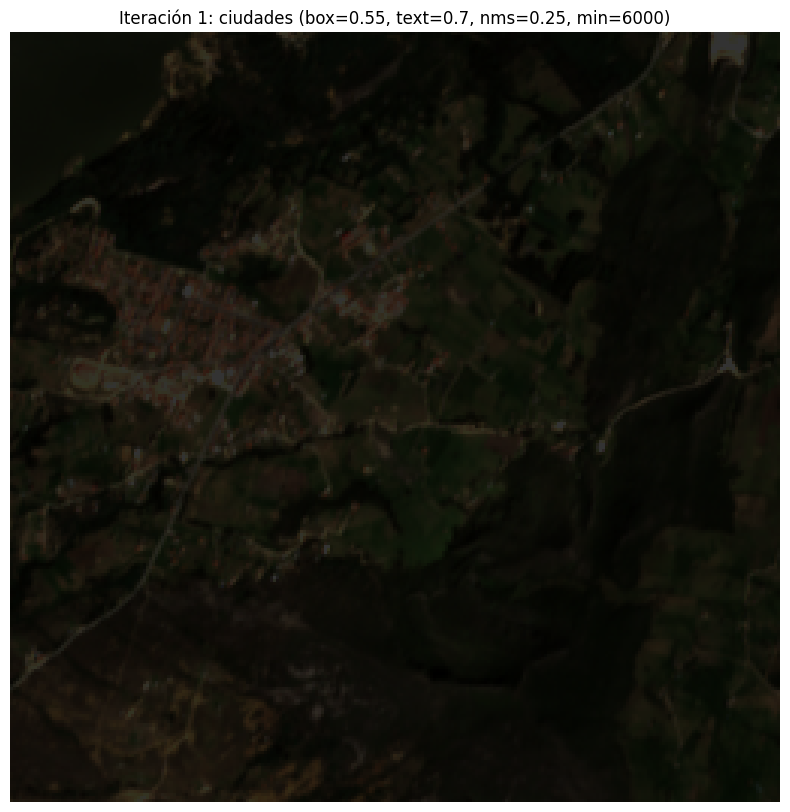

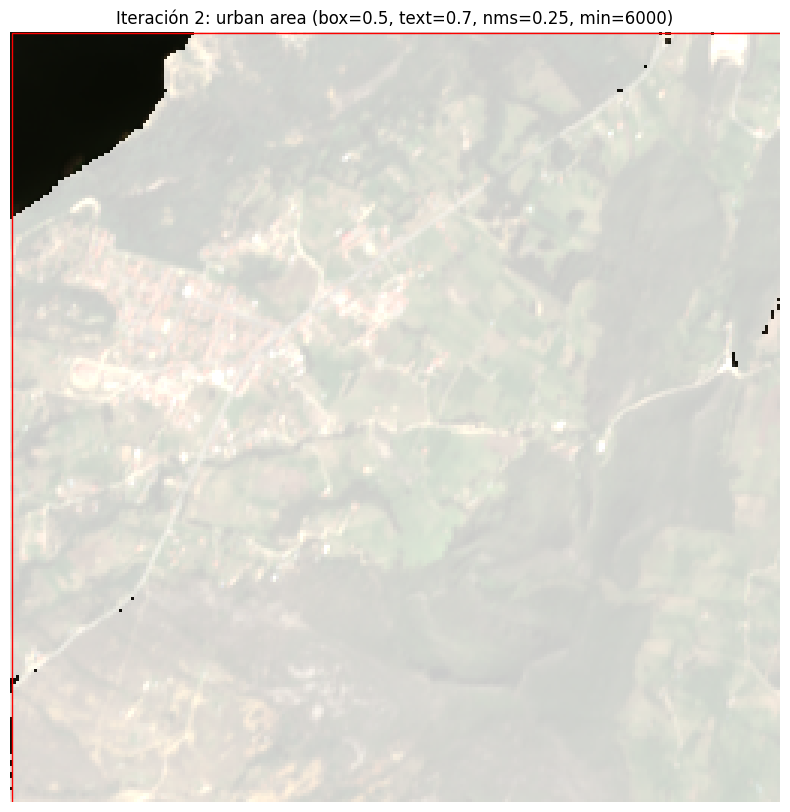

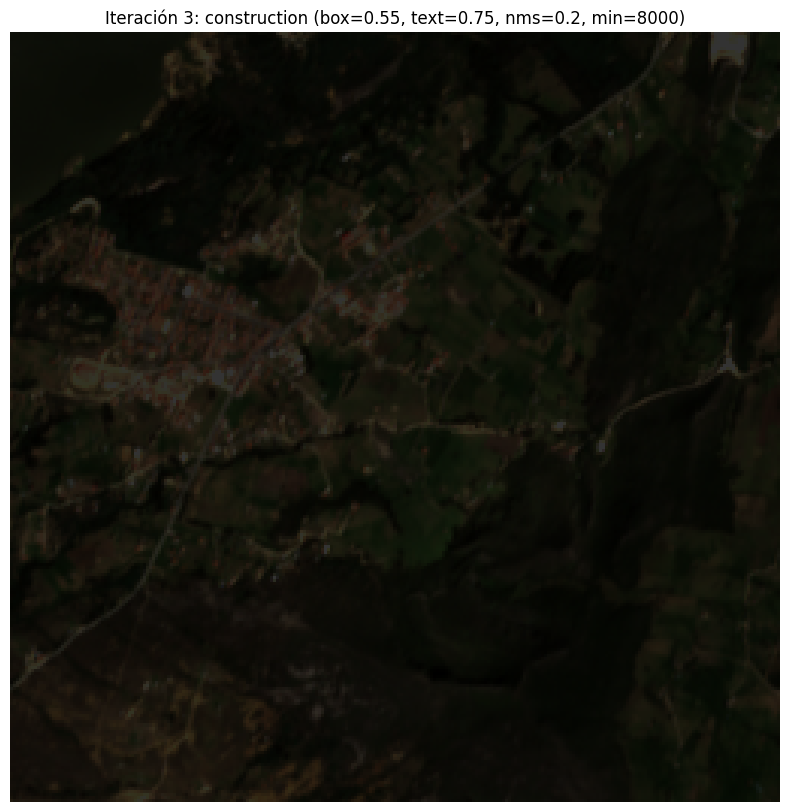

In [6]:
prueba_prompts = [
    {"prompt": "ciudades",     "box": 0.55, "text": 0.70, "nms": 0.25, "min_area": 6000},
    {"prompt": "urban area",  "box": 0.50, "text": 0.70, "nms": 0.25, "min_area": 6000},
    {"prompt": "construction",     "box": 0.55, "text": 0.75, "nms": 0.20, "min_area": 8000},
]
img = "../tiles/Sentinel/Guatavita_4_crop.tif"
out = "../tiles/segmentation_text"

for i, cfg in enumerate(prueba_prompts, 1):
    sam.predict(
        img, cfg["prompt"],
        box_threshold=cfg["box"],
        text_threshold=cfg["text"],
        nms_threshold=cfg["nms"],
        min_area=cfg["min_area"],
        output=None  # evita guardar intermedio ruidoso
    )
    sam.show_anns(
        cmap="Greys_r",
        add_boxes=True,
        alpha=0.8,
        title=f"Iteración {i}: {cfg['prompt']} "
              f"(box={cfg['box']}, text={cfg['text']}, nms={cfg['nms']}, min={cfg['min_area']})",
        blend=False,
        output=f"{out}/Guatavita_4_{i}.tif",
    )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

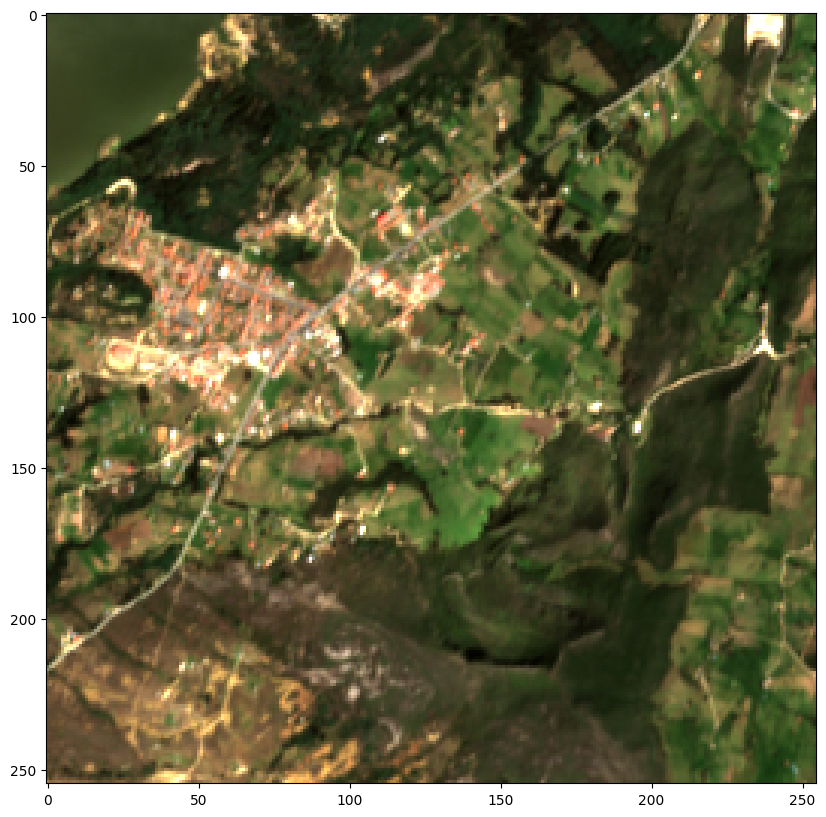

In [7]:
# SIN llamar a torch.cuda.empty_cache() ni a nada de CUDA
from samgeo import SamGeo
import os

boxes = [-73.83875, 4.92954, -73.82584, 4.93873]

img_path = "../tiles/Sentinel/Guatavita_4_crop.tif"
out_dir  = "../tiles/segmentation_text"
os.makedirs(out_dir, exist_ok=True)

sam = SamGeo(model_type="vit_h",automatic=False,sam_kwargs=None, point_crs="EPSG:4326")
sam.set_image(img_path)

sam.predict(
    boxes=boxes,  # listas (no numpy/torch)
    output=os.path.join(out_dir, "mask.tif"),
    dtype="uint8",
)

sam.show_anns(
        cmap="Greys_r",
        add_boxes=True,
        alpha=0.8,
        title="Segmentacion de cuerpos de agua",
        blend=False,
)



In [8]:
# Prompts más específicos para edificaciones
urban_prompts = [
    "residential buildings",
    "houses rooftops", 
    "urban structures",
    "building roofs",
    "constructed areas",
    "residential area",
    "built environment"
]

# Probar diferentes configuraciones
for prompt in urban_prompts:
    sam.predict('../tiles/Sentinel/Guatavita_4_crop.tif', prompt, 
                box_threshold=0.2, text_threshold=0.6)
    
    mask = save_masks_manually(f"../tiles/segmentation_text/urban_{prompt.replace(' ', '_')}.tif")

# Configuraciones optimizadas para detección urbana
urban_configs = [
    {"box": 0.15, "text": 0.4},  # Menos restrictivo
    {"box": 0.25, "text": 0.5},  # Balance medio
    {"box": 0.35, "text": 0.7},  # Más específico
]

for i, config in enumerate(urban_configs):
    sam.predict('../tiles/Sentinel/Guatavita_4_crop.tif', "buildings residential", 
                box_threshold=config['box'], text_threshold=config['text'])
    
    mask = save_masks_manually(f"../tiles/segmentation_text/urban_config_{i+1}.tif")

# Función para combinar múltiples detecciones
def segment_urban_combined(image_path, output_path):
    """
    Combina múltiples prompts urbanos para mejor detección
    """
    prompts_urbanos = [
        "residential buildings",
        "houses rooftops",
        "urban infrastructure", 
        "built structures"
    ]
    
    combined_mask = None
    
    for prompt in prompts_urbanos:
        sam.predict(image_path, prompt, box_threshold=0.2, text_threshold=0.5)
        
        if hasattr(sam, 'masks') and sam.masks is not None and len(sam.masks) > 0:
            # Crear máscara individual
            current_mask = np.zeros_like(sam.masks[0], dtype=np.uint8)
            
            for mask in sam.masks:
                mask_uint8 = (mask * 255).astype(np.uint8)
                current_mask = np.maximum(current_mask, mask_uint8)
            
            # Combinar con máscara acumulada
            if combined_mask is None:
                combined_mask = current_mask
            else:
                combined_mask = np.maximum(combined_mask, current_mask)
    
    # Guardar resultado combinado
    if combined_mask is not None:
        with rasterio.open('../tiles/Sentinel/Guatavita_4_crop.tif') as src:
            profile = src.profile.copy()
            profile.update(dtype='uint8', count=1)
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(combined_mask, 1)
        
        print(f"✅ Segmentación urbana combinada guardada: {output_path}")
        print(f"   • Píxeles detectados: {np.sum(combined_mask > 0):,}")
        
        return combined_mask
    
    return None

# Ejecutar segmentación combinada
urban_mask = segment_urban_combined(
    '../tiles/Sentinel/Guatavita_4_crop.tif',
    '../tiles/segmentation_text/Guatavita_4_urban_combined.tif'
)

DataSourceError: '../tiles/Sentinel/Guatavita_4_crop.tif' not recognized as being in a supported file format.; It might help to specify the correct driver explicitly by prefixing the file path with '<DRIVER>:', e.g. 'CSV:path'.

In [5]:
def geojson_to_raster(geojson_path, reference_tif_path, output_path, codigo_filtro=512):
    """
    Convierte un GeoJSON a raster usando un archivo TIFF de referencia
    
    Args:
        geojson_path: Ruta al archivo GeoJSON
        reference_tif_path: Ruta al TIFF de referencia para obtener dimensiones y proyección
        output_path: Ruta donde guardar el raster resultante
        codigo_filtro: Código a filtrar en el GeoJSON
    """
    gdf = gpd.read_file(geojson_path)
    gdf_filtrado = gdf[gdf['codigo'] == codigo_filtro]
    
    with rasterio.open(reference_tif_path) as ref:
        transform = ref.transform
        width = ref.width
        height = ref.height
        crs = ref.crs
    
    mask = features.rasterize(
            ((geom, 0) for geom in gdf_filtrado.geometry),
            out_shape=(height, width),
            transform=transform,
            fill=1,
            dtype='uint8'
    )
    
    # Guardar el raster
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=mask.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(mask, 1)
        
    return mask

In [10]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_0_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_0_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_0_crop_raster.tif',
    codigo_filtro=512
)

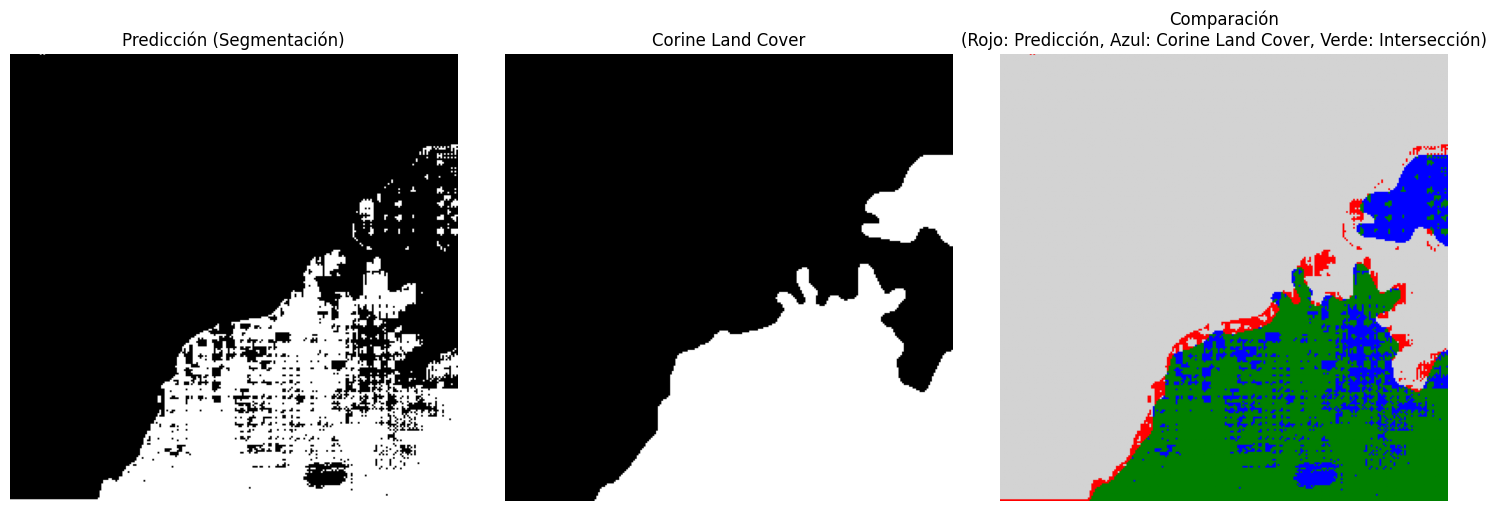

IoU (Intersection over Union): 0.7009
DICE Coefficient:              0.8242
Pixel Accuracy:                0.9065
TPR (Sensitivity/Recall):      0.9134
FPR (False Positive Rate):     0.0957


In [6]:
def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 == target_value).astype(int)
    
    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1)
    comparison[mask1 == 1] = 1
    comparison[mask2 == 1] = 2
    comparison[(mask1 == 1) & (mask2 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(mask1, cmap='gray')
    axes[0].set_title('Predicción (Segmentación)')
    axes[0].axis('off')
    
    axes[1].imshow(mask2, cmap='gray')
    axes[1].set_title('Corine Land Cover')
    axes[1].axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    im = axes[2].imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes[2].set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas de forma organizada
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_0_crop_raster.tif',
    mask_path='../tiles/segmentation_text/Guatavita_0_water.tif',
    target_value=0
)

print_metrics(results)

In [7]:
def print_metrics_percent(results):
    """
    Imprime las métricas en formato porcentaje (2 decimales).
    Acepta diccionarios con keys como 'IoU','DICE','Pixel_Accuracy','F1_Score' o 'F1',
    'TPR_Sensitivity_Recall','FPR','Precision' y contadores 'TP','FP','TN','FN'.
    """
    if results is None:
        print("No hay resultados para mostrar.")
        return

    def pct(x):
        return f"{x*100:.2f}%" if (x is not None and not isinstance(x, (int,))) else ("N/A" if x is None else f"{x:.2f}%")

    # Obtener valores seguros (maneja nombres alternativos)
    iou = results.get("IoU")
    dice = results.get("DICE")
    pixel = results.get("Pixel_Accuracy")
    f1 = results.get("F1_Score", results.get("F1"))
    tpr = results.get("TPR_Sensitivity_Recall")
    fpr = results.get("FPR")
    precision = results.get("Precision")

    # Contadores absolutos (no convertir a %)
    tp = results.get("TP")
    fp = results.get("FP")
    tn = results.get("TN")
    fn = results.get("FN")

    print(f"\n🎯 MÉTRICAS PRINCIPALES:")
    print(f"   • IoU (Intersection over Union): {pct(iou)}")
    print(f"   • DICE Coefficient:              {pct(dice)}")
    print(f"   • Pixel Accuracy:                {pct(pixel)}")
    print(f"   • F1-Score:                      {pct(f1)}")

    print(f"\n📊 SENSIBILIDAD Y ESPECIFICIDAD:")
    print(f"   • TPR (Sensitivity / Recall):    {pct(tpr)}")
    print(f"   • FPR (False Positive Rate):     {pct(fpr)}")
    print(f"   • Precision:                     {pct(precision)}")

    print(f"\n🔢 MATRIZ DE CONFUSIÓN (conteos):")
    print(f"   • True Positives (TP):           {int(tp) if tp is not None else 'N/A'}")
    print(f"   • False Positives (FP):          {int(fp) if fp is not None else 'N/A'}")
    print(f"   • True Negatives (TN):           {int(tn) if tn is not None else 'N/A'}")
    print(f"   • False Negatives (FN):          {int(fn) if fn is not None else 'N/A'}")

In [11]:
def plot_mask_with_coords(mask, reference_tif, out_png=None, cmap='gray', title=None, n_ticks=5, dpi=200):
    """
    Muestra y opcionalmente guarda una máscara con eje cartesiano (coordenadas del raster de referencia).
    - mask: 2D numpy array (0/1 or 0/255)
    - reference_tif: ruta al TIFF usado como referencia (para transform y CRS)
    - out_png: ruta de salida PNG (si None solo muestra)
    - cmap: colormap para la máscara
    - title: título del gráfico
    - n_ticks: número de marcas por eje
    """
    import os
    import numpy as np
    import rasterio
    import matplotlib.pyplot as plt
    from rasterio.transform import array_bounds

    h, w = mask.shape
    with rasterio.open(reference_tif) as src:
        transform = src.transform
        crs = src.crs

    # obtener bounds en coordenadas del CRS
    minx, miny, maxx, maxy = array_bounds(h, w, transform)
    extent = (minx, maxx, miny, maxy)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(mask, cmap=cmap, extent=extent, origin='upper')
    ax.set_title(title or os.path.basename(reference_tif))
    # etiquetas con CRS breve
    crs_label = crs.to_string() if crs is not None else "CRS"
    ax.set_xlabel(f'X ({crs_label})')
    ax.set_ylabel(f'Y ({crs_label})')

    if out_png:
        os.makedirs(os.path.dirname(out_png) or '.', exist_ok=True)
        plt.savefig(out_png, bbox_inches='tight', dpi=dpi)
    plt.show()
    return fig, ax


🔄 Procesando tile 0 -> tipo 'agua' (codigo 512)
PARÁMETROS:
   • Tipo de cobertura: agua
   • Descripción: Cuerpos de agua
   • Código CORINE: 512
   • Prompt: 'agua, cuerpo de agua, lago, embalse, superficie de agua, laguna'
   • Tile: 0
PASO 1: SEGMENTACIÓN CON SAM
   • Entrada: ../tiles/Sentinel/Guatavita_0_crop.tif
   • Salida: ../tiles/segmentation_text/Guatavita_0_agua_auto.tif
Segmentación completada
PASO 2: CONVERSIÓN GEOJSON A RASTER
   • Entrada: ../tiles/LandUse/Guatavita_0_crop.geojson
   • Código filtro: 512
   • Salida: ../tiles/LandUseRaster/Guatavita_0_agua_raster_auto.tif
PASO 3: CÁLCULO DE MÉTRICAS


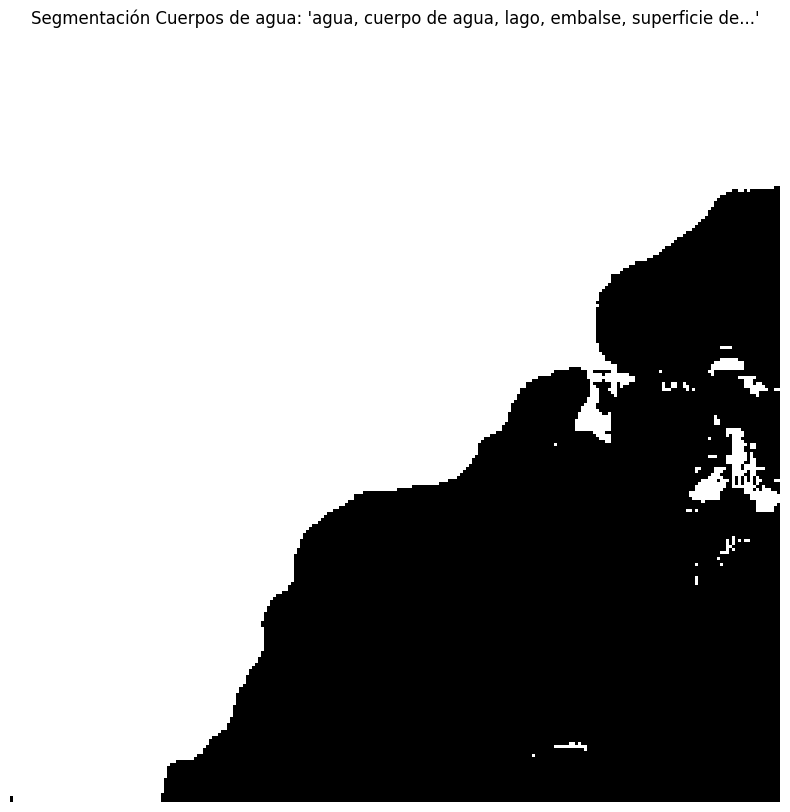

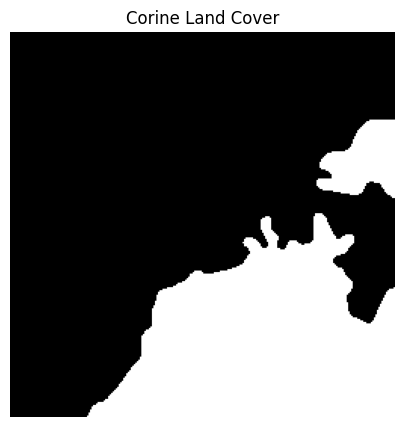

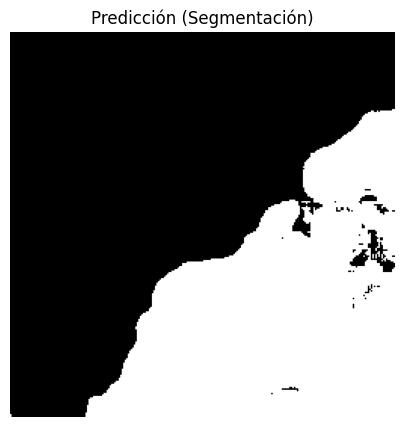

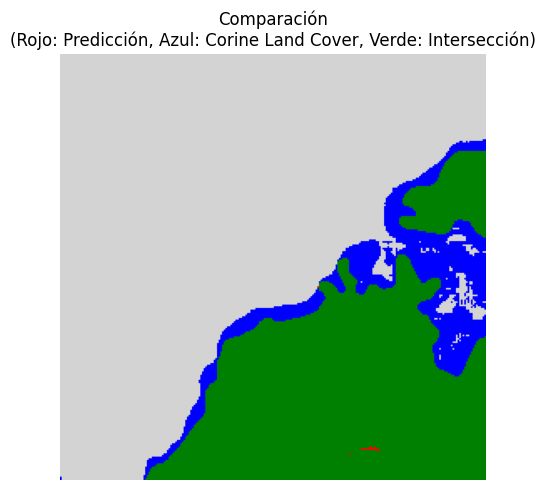


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 79.24%
   • DICE Coefficient:              88.42%
   • Pixel Accuracy:                92.36%
   • F1-Score:                      88.42%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    99.91%
   • FPR (False Positive Rate):     10.76%
   • Precision:                     79.30%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           18967
   • False Positives (FP):          4952
   • True Negatives (TN):           41089
   • False Negatives (FN):          17
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_0_agua_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_0_agua_raster_auto.tif

🔄 Procesando tile 1 -> tipo 'agua' (codigo 512)
PARÁMETROS:
   • Tipo de cobertura: agua
   • Descripción: Cuerpos de agua
   • Código CORINE: 512
   • Prompt: 'agua, cuerpo de agua, lago, embalse, superficie de agua, laguna'
   • Tile: 1
PASO 1: SEGMENTACIÓN CON SAM
   • Entrada: ..

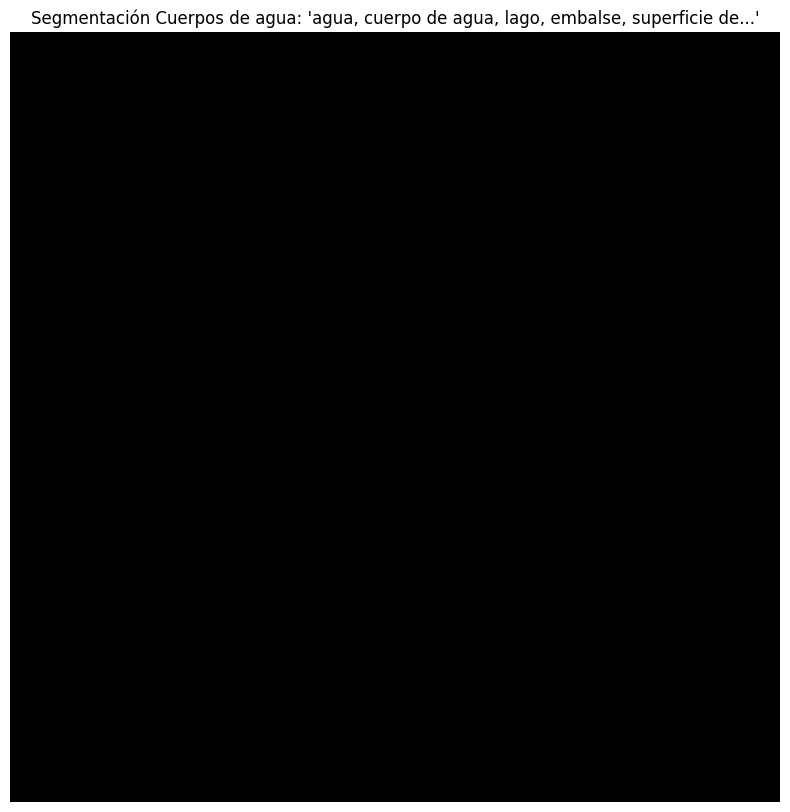

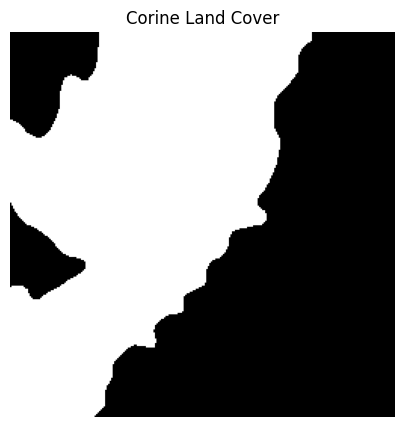

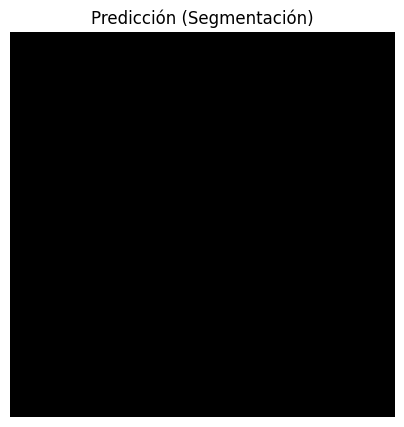

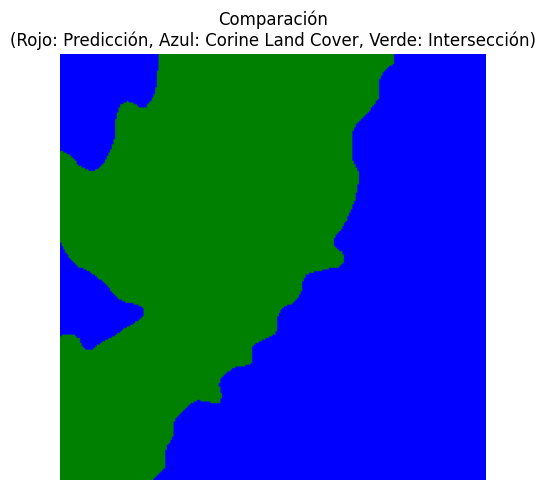


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 48.29%
   • DICE Coefficient:              65.13%
   • Pixel Accuracy:                48.29%
   • F1-Score:                      65.13%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     48.29%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           31398
   • False Positives (FP):          33627
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_1_agua_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_1_agua_raster_auto.tif

🔄 Procesando tile 2 -> tipo 'agua' (codigo 512)
PARÁMETROS:
   • Tipo de cobertura: agua
   • Descripción: Cuerpos de agua
   • Código CORINE: 512
   • Prompt: 'agua, cuerpo de agua, lago, embalse, superficie de agua, laguna'
   • Tile: 2
PASO 1: SEGMENTACIÓN CON SAM
   • Entrada: ../t

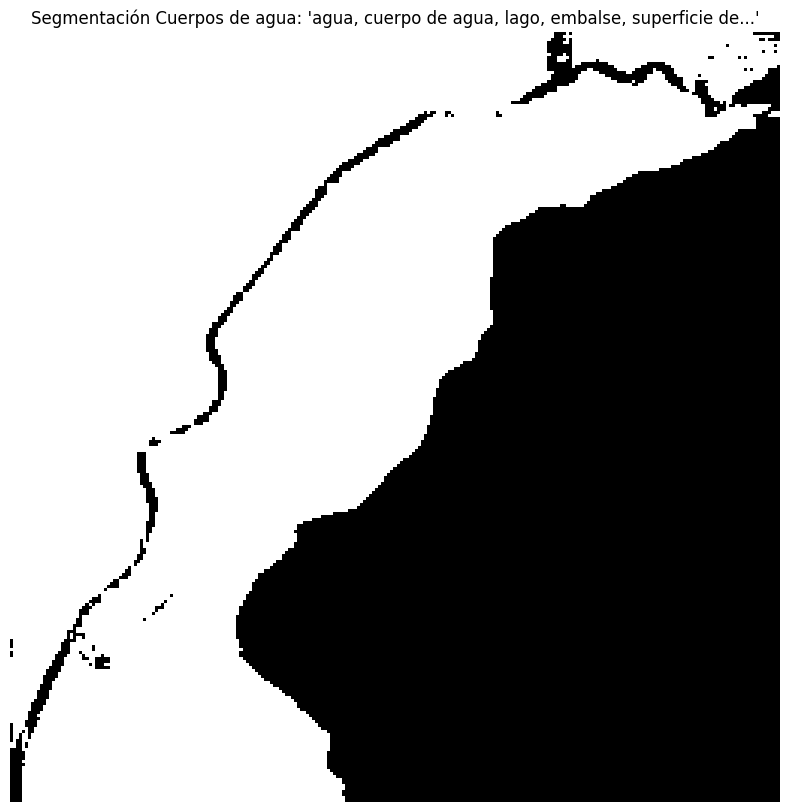

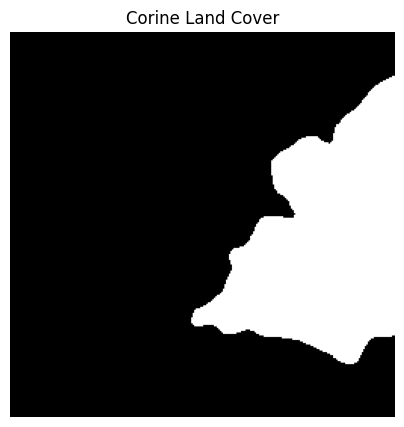

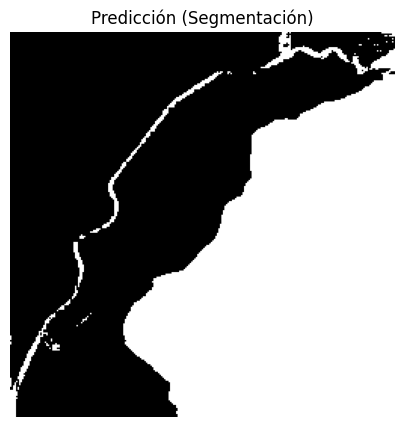

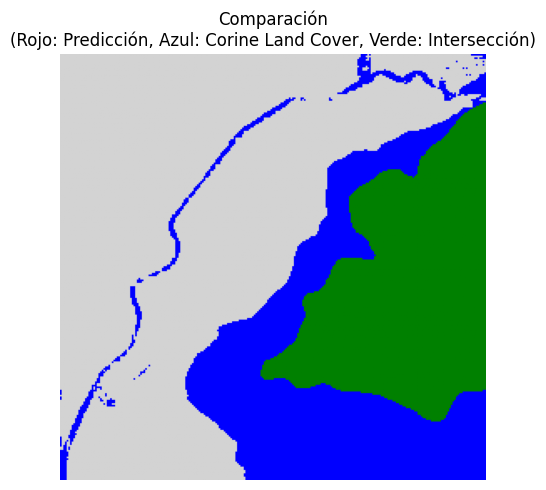


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 49.28%
   • DICE Coefficient:              66.03%
   • Pixel Accuracy:                77.37%
   • F1-Score:                      66.03%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     29.01%
   • Precision:                     49.28%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           14299
   • False Positives (FP):          14715
   • True Negatives (TN):           36011
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_2_agua_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_2_agua_raster_auto.tif

🔄 Procesando tile 3 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Tile

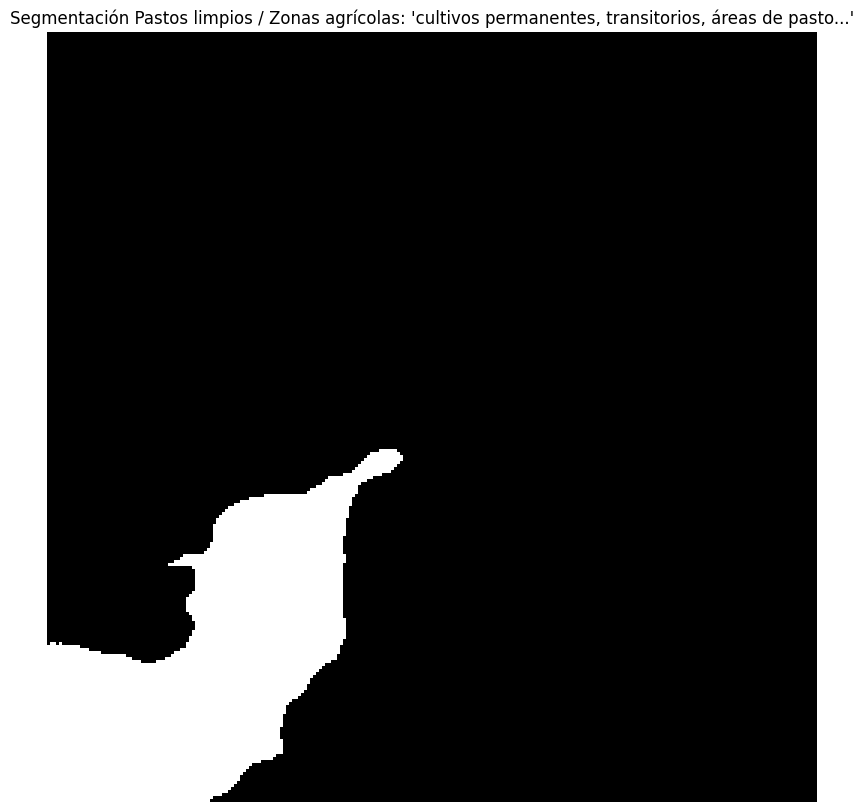

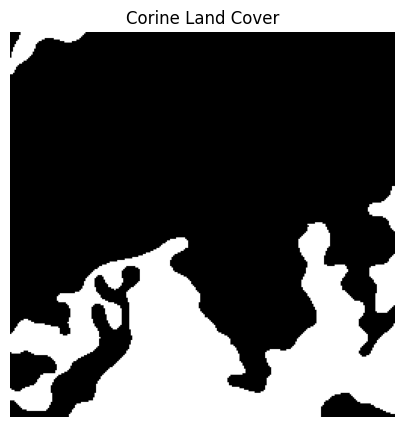

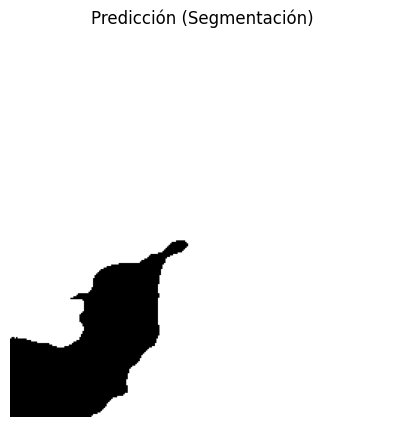

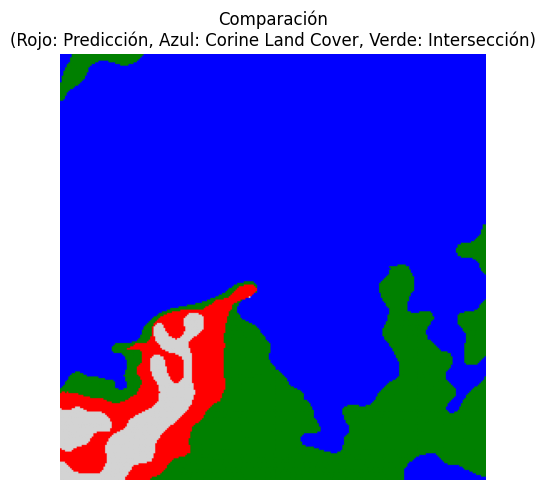


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 21.26%
   • DICE Coefficient:              35.07%
   • Pixel Accuracy:                24.60%
   • F1-Score:                      35.07%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    77.89%
   • FPR (False Positive Rate):     94.27%
   • Precision:                     22.63%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           13241
   • False Positives (FP):          45274
   • True Negatives (TN):           2752
   • False Negatives (FN):          3758
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_3_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_3_agricola_raster_auto.tif

🔄 Procesando tile 4 -> tipo 'urbano' (codigo 111)
PARÁMETROS:
   • Tipo de cobertura: urbano
   • Descripción: Tejido urbano continuo
   • Código CORINE: 111
   • Prompt: 'construction'
   • Tile: 4
PASO 1: SEGMENTACIÓN CON SAM
   • Entrada: ../tiles/Sentinel/Guatavita_4_cr

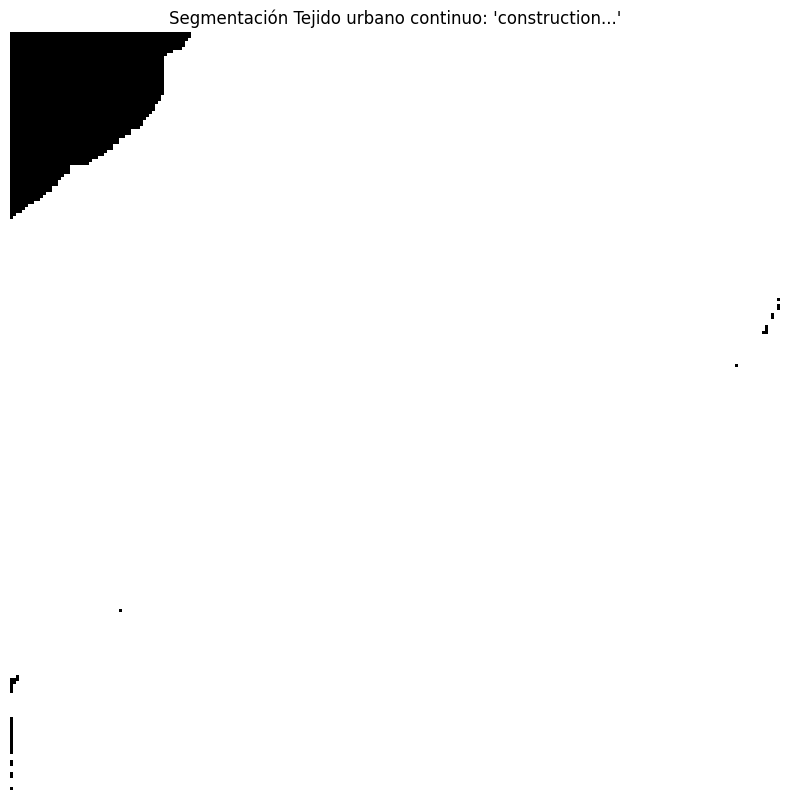

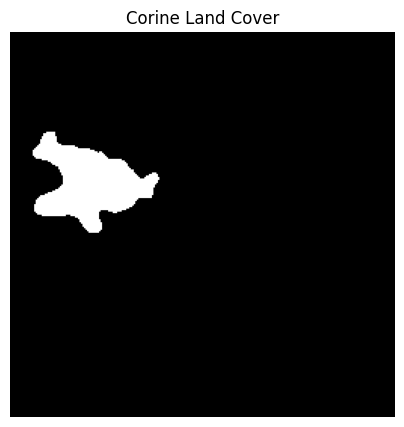

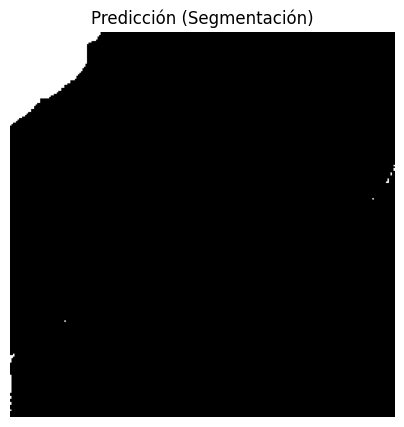

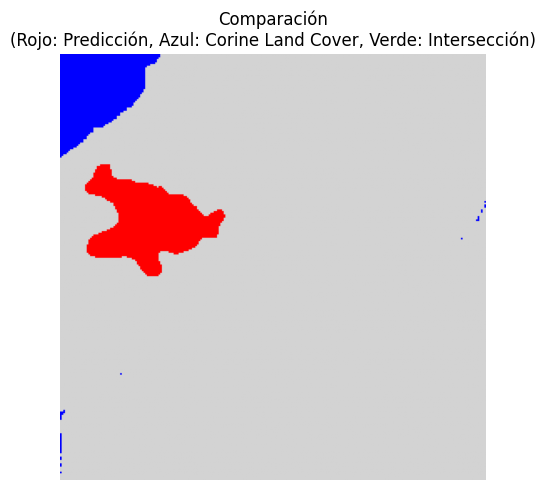


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.00%
   • DICE Coefficient:              0.00%
   • Pixel Accuracy:                92.14%
   • F1-Score:                      0.00%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.00%
   • FPR (False Positive Rate):     3.68%
   • Precision:                     0.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           0
   • False Positives (FP):          2289
   • True Negatives (TN):           59911
   • False Negatives (FN):          2825
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_4_urbano_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_4_urbano_raster_auto.tif

🔄 Procesando tile 5 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Tile: 5
P

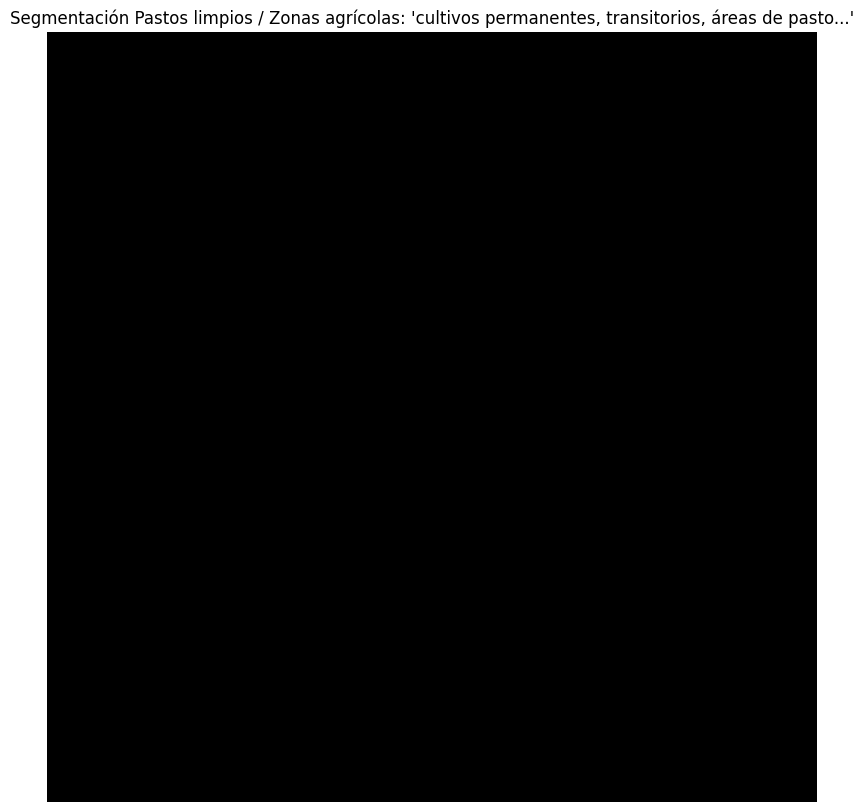

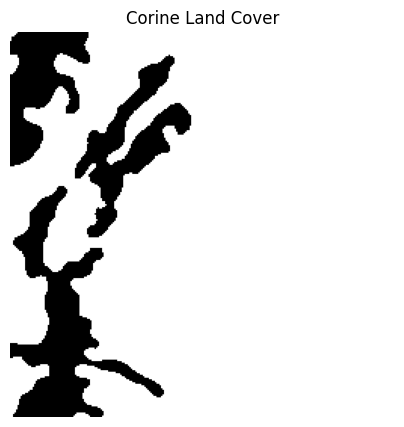

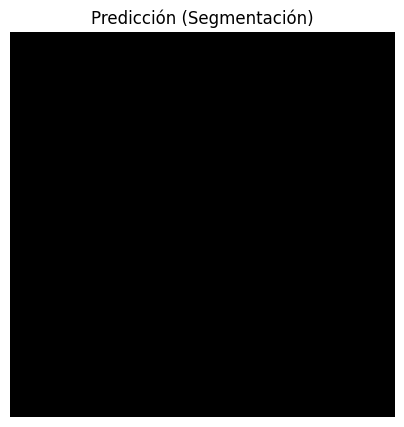

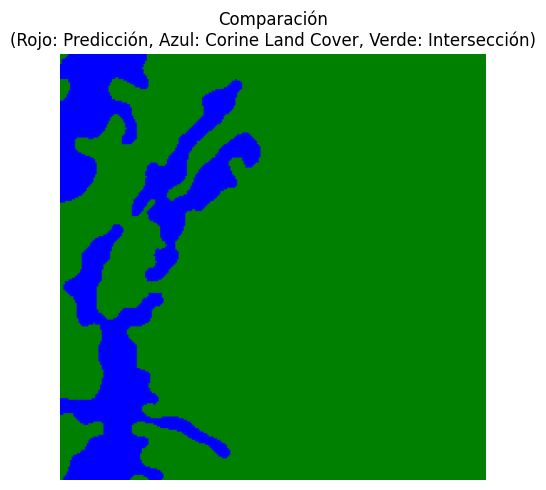


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 84.60%
   • DICE Coefficient:              91.66%
   • Pixel Accuracy:                84.60%
   • F1-Score:                      91.66%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     84.60%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           55012
   • False Positives (FP):          10013
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_5_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_5_agricola_raster_auto.tif

🔄 Procesando tile 6 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   •

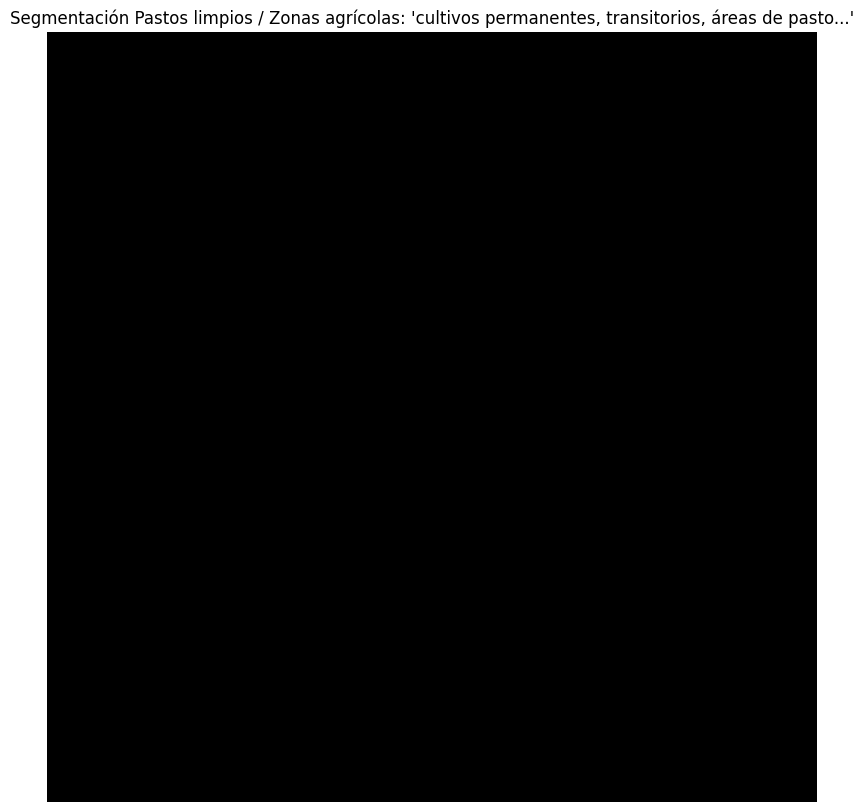

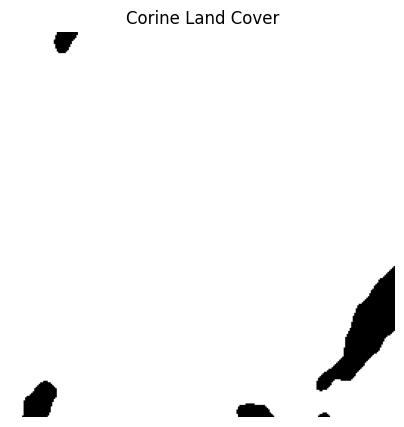

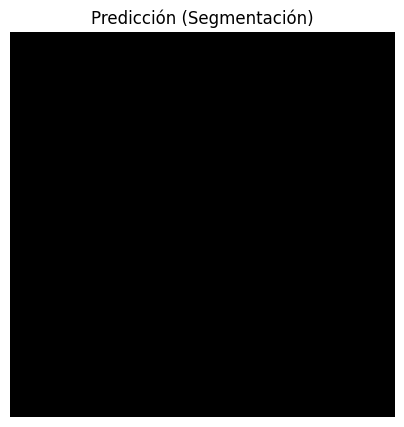

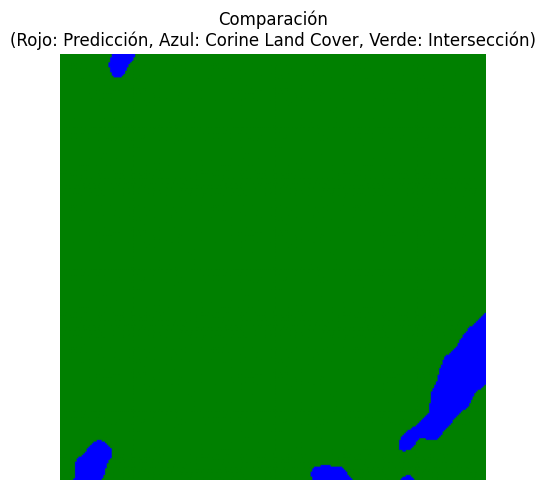


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 96.41%
   • DICE Coefficient:              98.17%
   • Pixel Accuracy:                96.41%
   • F1-Score:                      98.17%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     96.41%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           62689
   • False Positives (FP):          2336
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_6_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_6_agricola_raster_auto.tif

🔄 Procesando tile 7 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia 

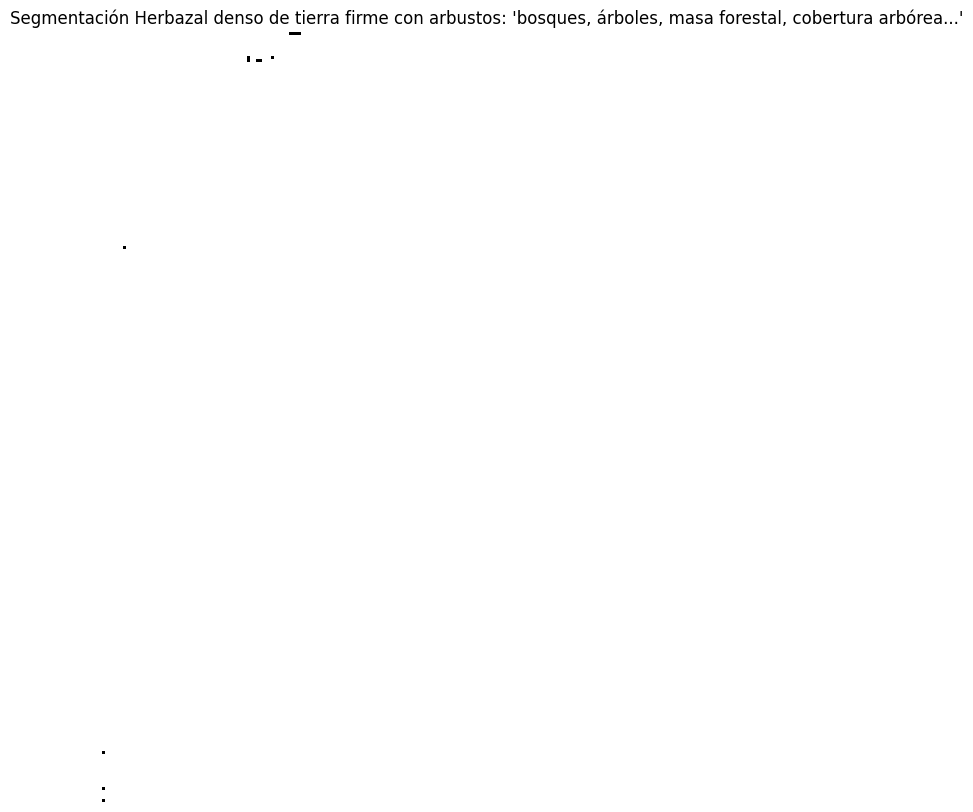

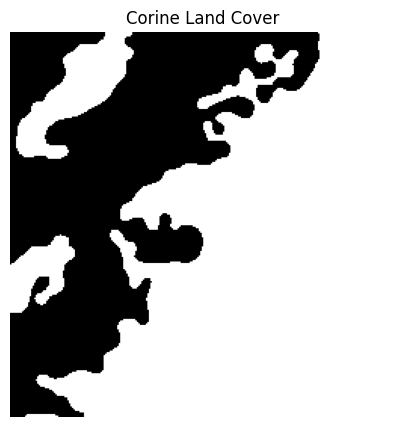

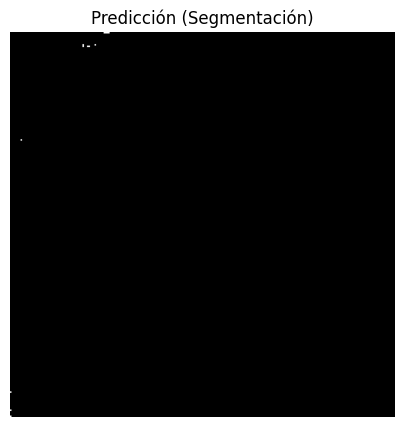

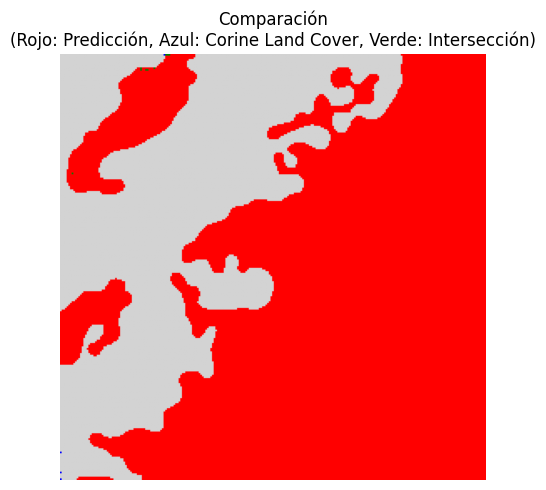


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.02%
   • DICE Coefficient:              0.04%
   • Pixel Accuracy:                35.84%
   • F1-Score:                      0.04%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.02%
   • FPR (False Positive Rate):     0.02%
   • Precision:                     69.23%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           9
   • False Positives (FP):          4
   • True Negatives (TN):           23297
   • False Negatives (FN):          41715
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_7_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_7_bosques_raster_auto.tif

🔄 Procesando tile 8 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia forestal

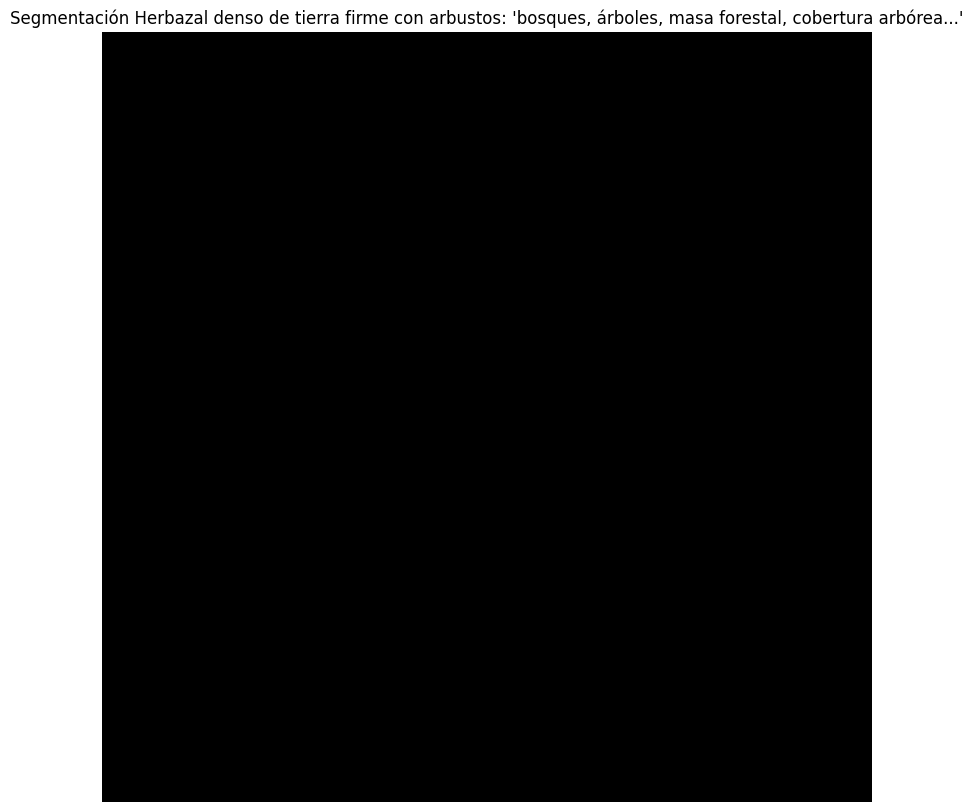

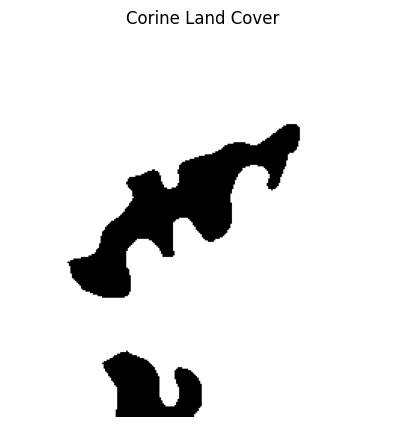

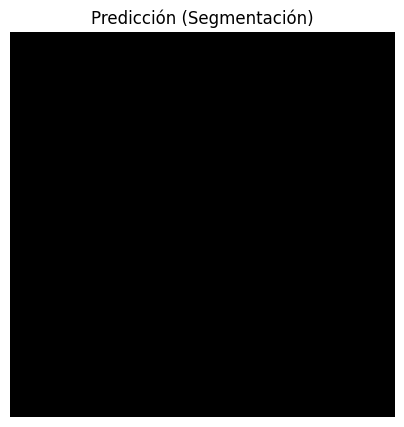

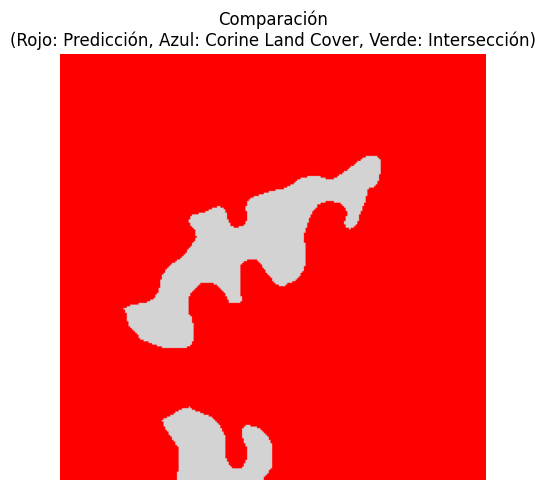


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.00%
   • DICE Coefficient:              0.00%
   • Pixel Accuracy:                11.33%
   • F1-Score:                      0.00%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.00%
   • FPR (False Positive Rate):     0.00%
   • Precision:                     0.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           0
   • False Positives (FP):          0
   • True Negatives (TN):           7367
   • False Negatives (FN):          57658
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_8_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_8_bosques_raster_auto.tif

🔄 Procesando tile 9 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia forestal, 

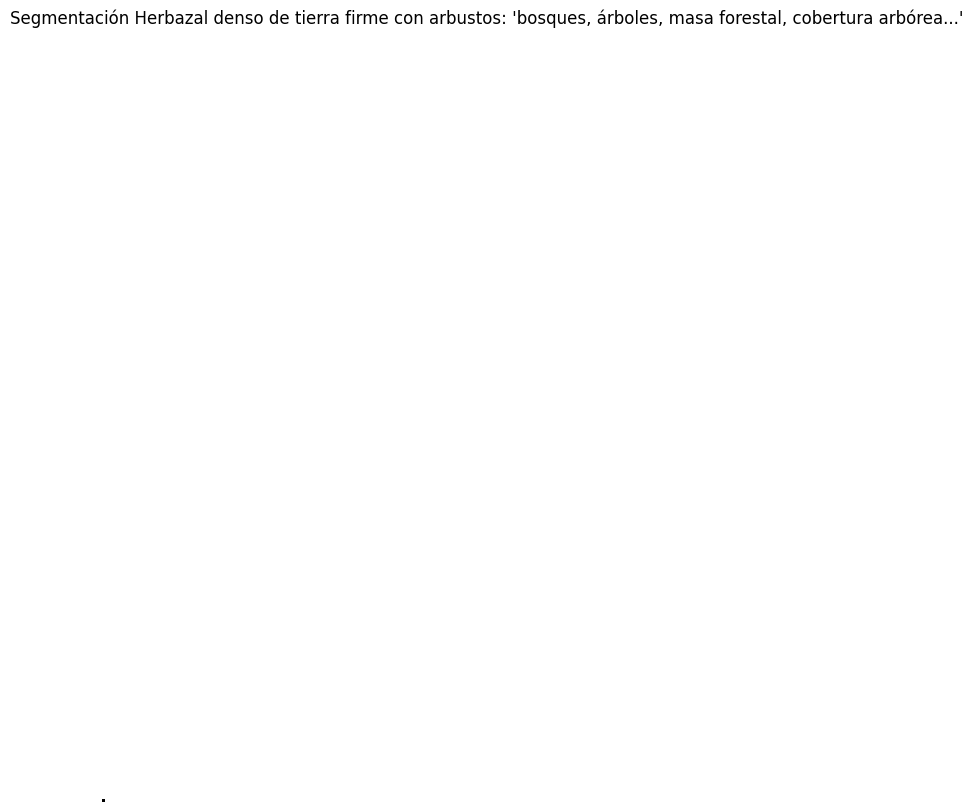

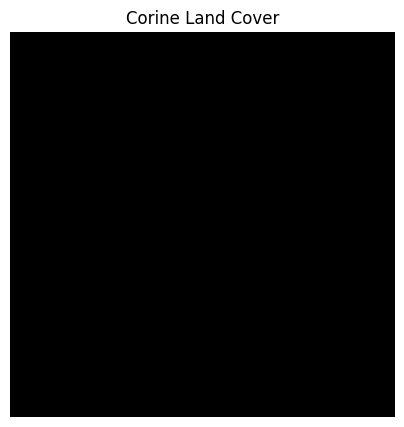

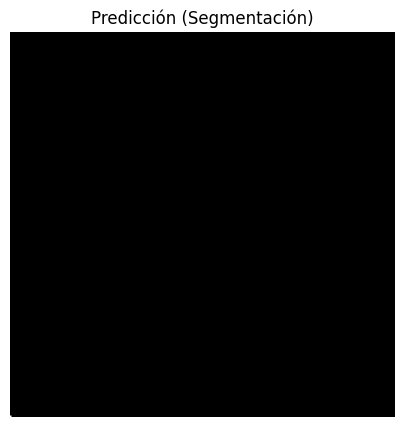

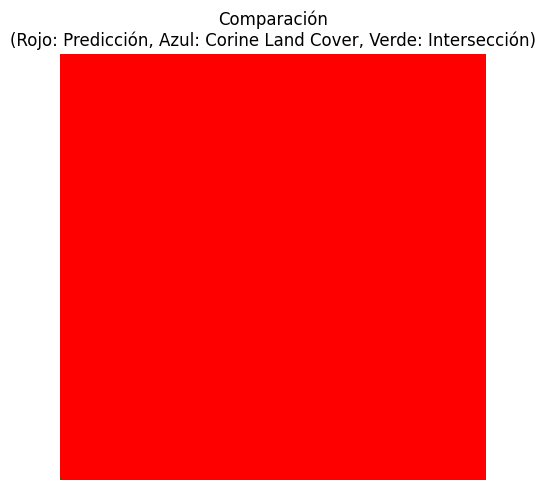


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.00%
   • DICE Coefficient:              0.00%
   • Pixel Accuracy:                0.00%
   • F1-Score:                      0.00%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.00%
   • FPR (False Positive Rate):     0.00%
   • Precision:                     100.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           1
   • False Positives (FP):          0
   • True Negatives (TN):           0
   • False Negatives (FN):          65024
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_9_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_9_bosques_raster_auto.tif

🔄 Procesando tile 10 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia forestal, p

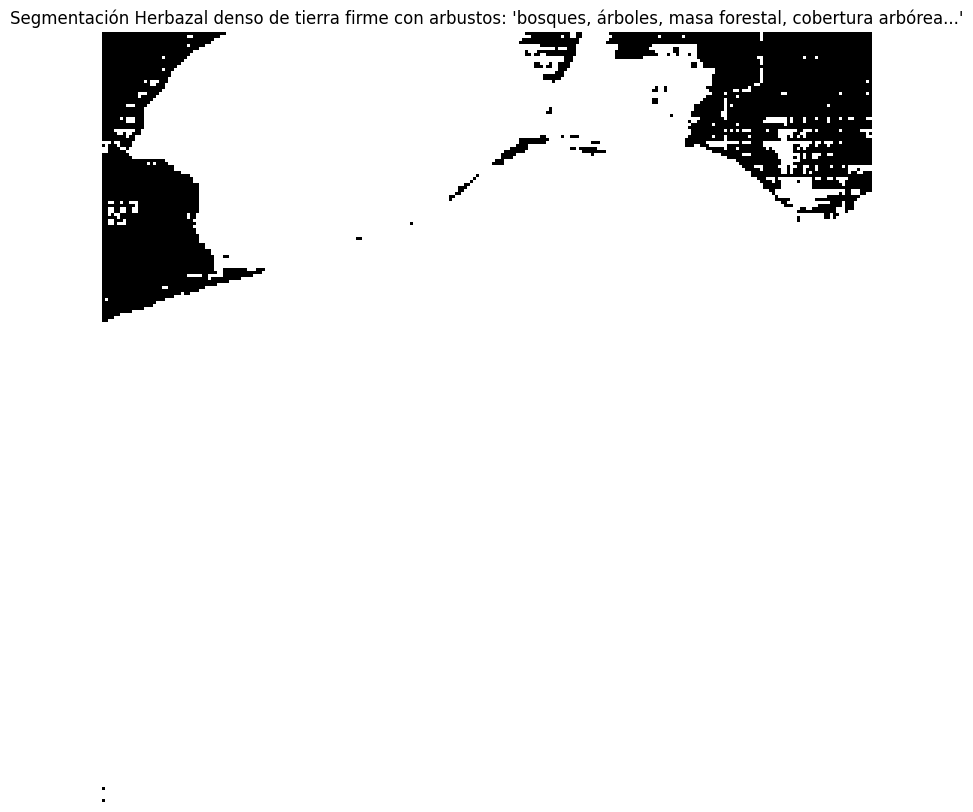

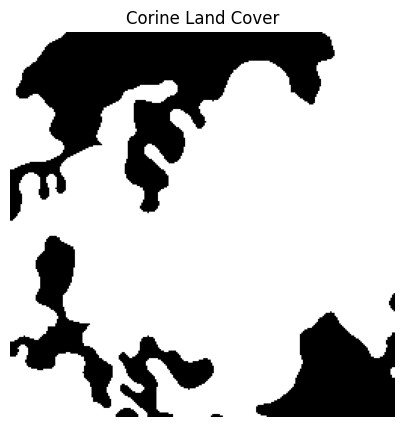

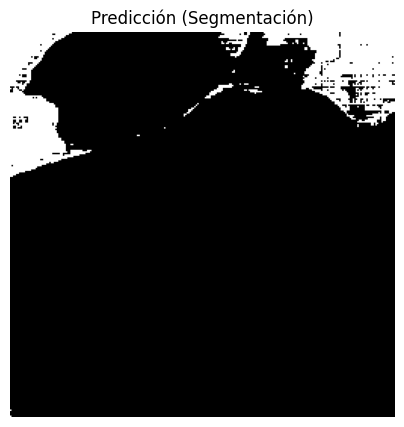

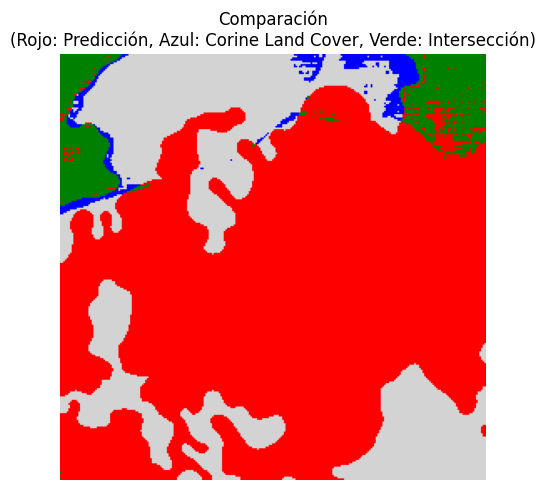


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 8.64%
   • DICE Coefficient:              15.91%
   • Pixel Accuracy:                33.09%
   • F1-Score:                      15.91%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    8.88%
   • FPR (False Positive Rate):     6.75%
   • Precision:                     76.58%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           4117
   • False Positives (FP):          1259
   • True Negatives (TN):           17401
   • False Negatives (FN):          42248
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_10_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_10_bosques_raster_auto.tif

🔄 Procesando tile 11 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canop

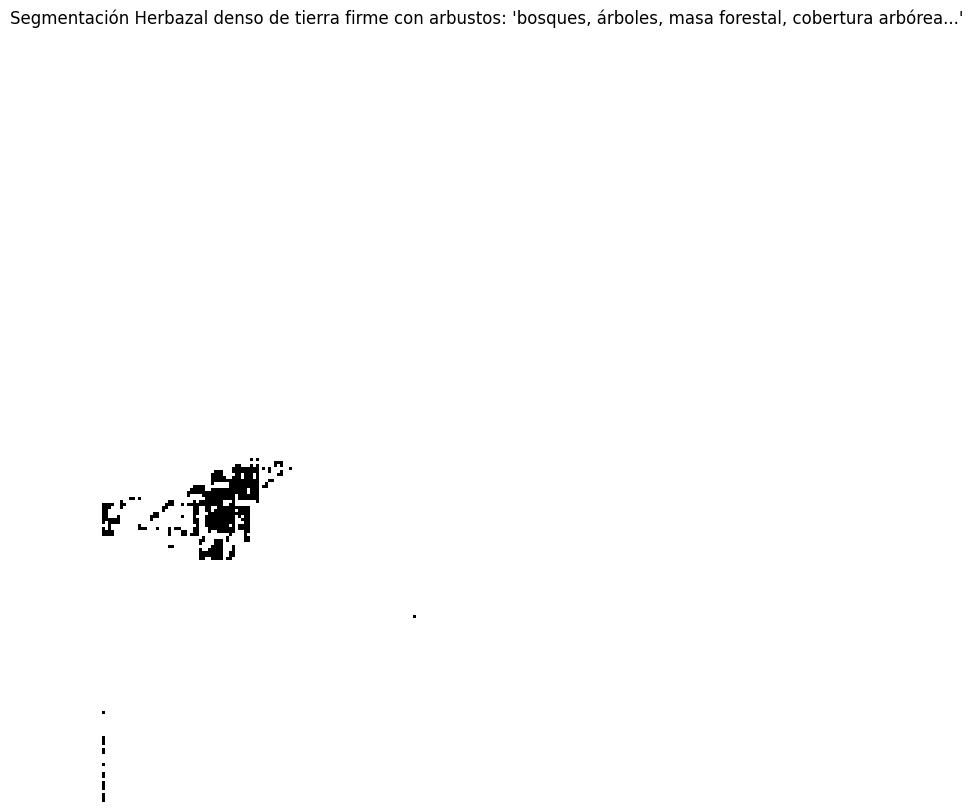

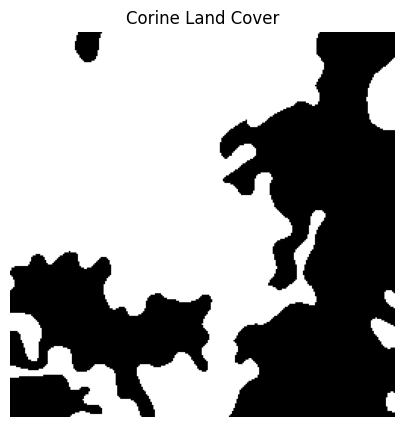

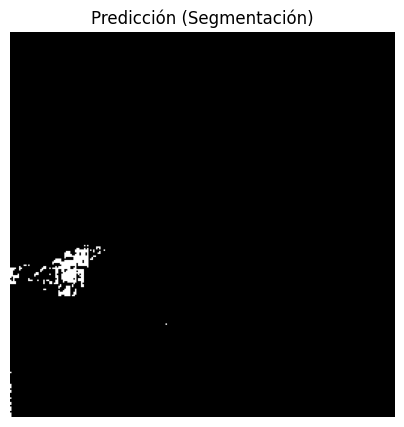

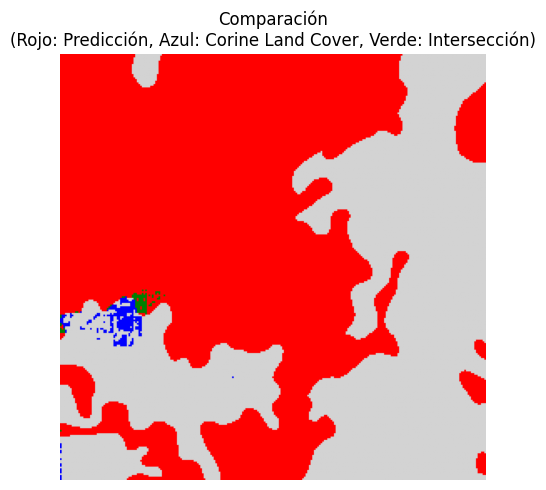


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.31%
   • DICE Coefficient:              0.63%
   • Pixel Accuracy:                42.84%
   • F1-Score:                      0.63%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.32%
   • FPR (False Positive Rate):     1.33%
   • Precision:                     23.78%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           117
   • False Positives (FP):          375
   • True Negatives (TN):           27738
   • False Negatives (FN):          36795
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_11_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_11_bosques_raster_auto.tif

🔄 Procesando tile 12 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia f

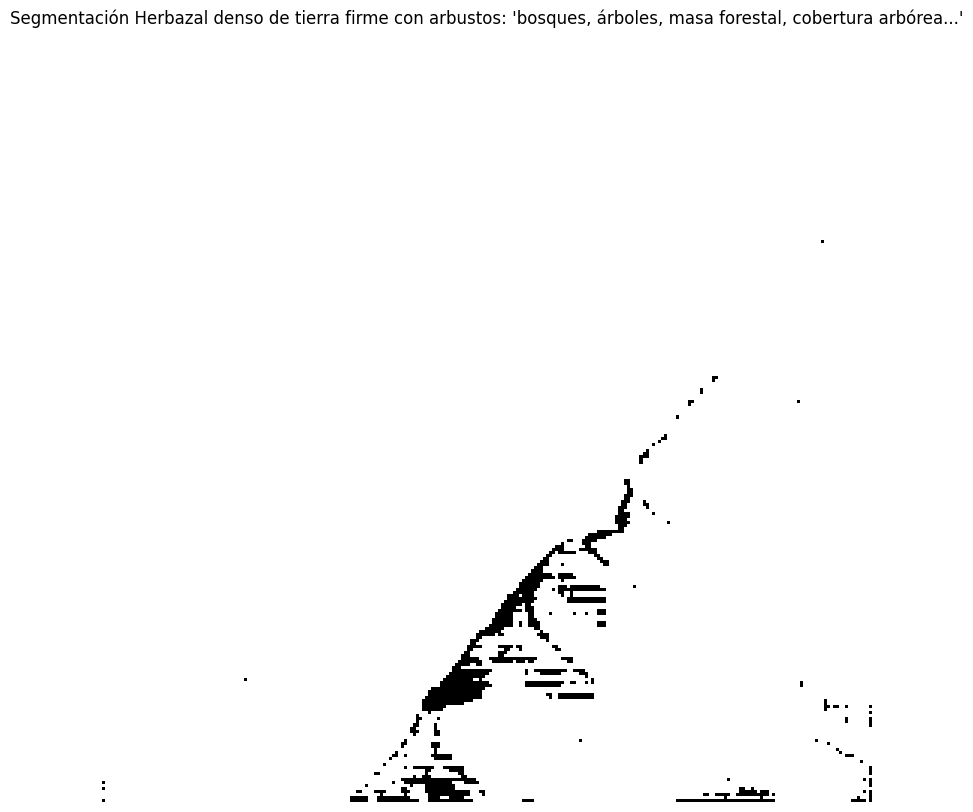

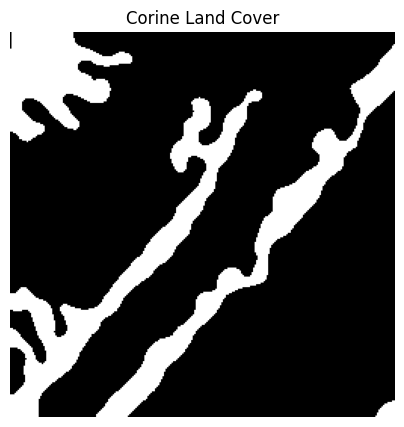

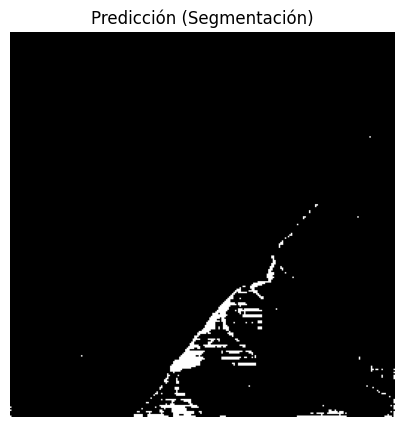

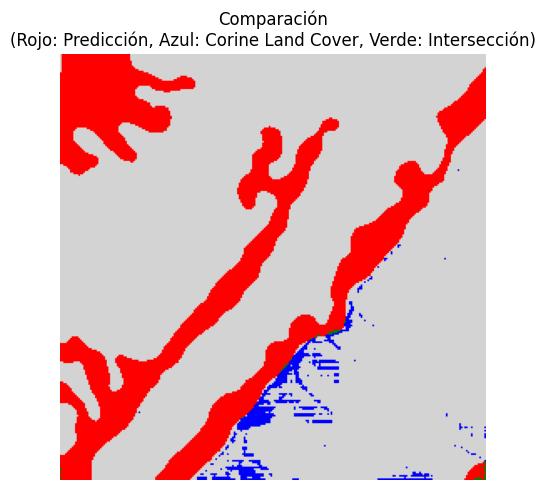


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.31%
   • DICE Coefficient:              0.62%
   • Pixel Accuracy:                77.99%
   • F1-Score:                      0.62%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.34%
   • FPR (False Positive Rate):     2.24%
   • Precision:                     3.73%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           45
   • False Positives (FP):          1163
   • True Negatives (TN):           50668
   • False Negatives (FN):          13149
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_12_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_12_bosques_raster_auto.tif

🔄 Procesando tile 13 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Ti

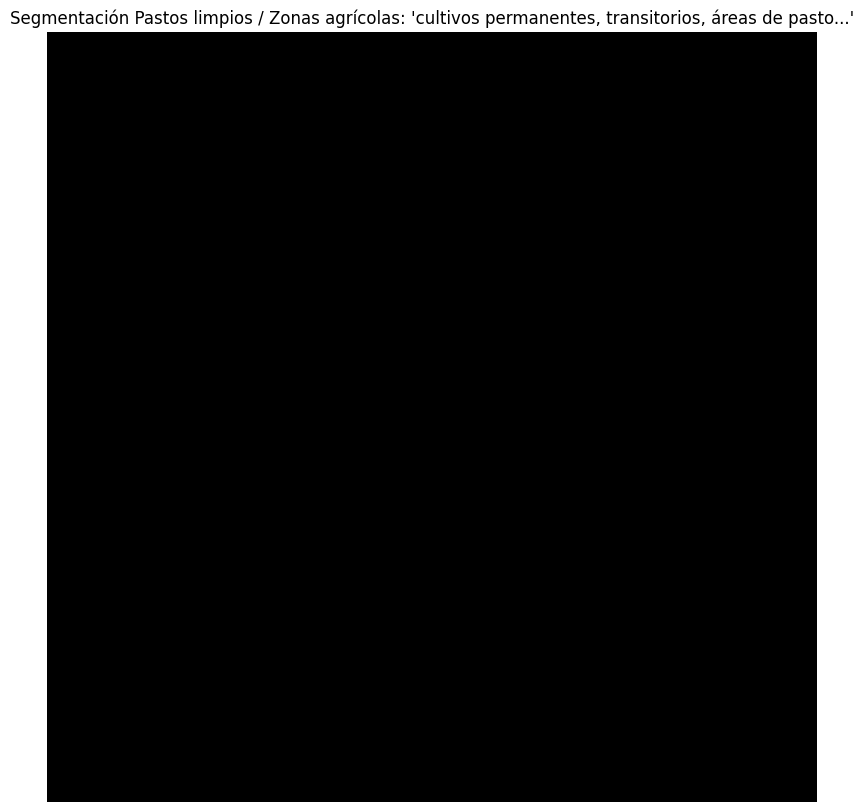

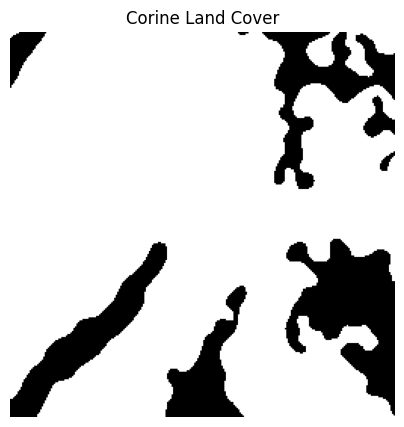

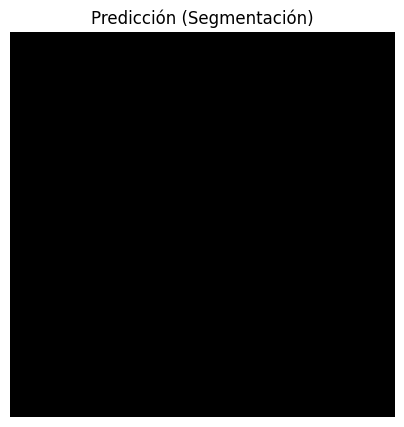

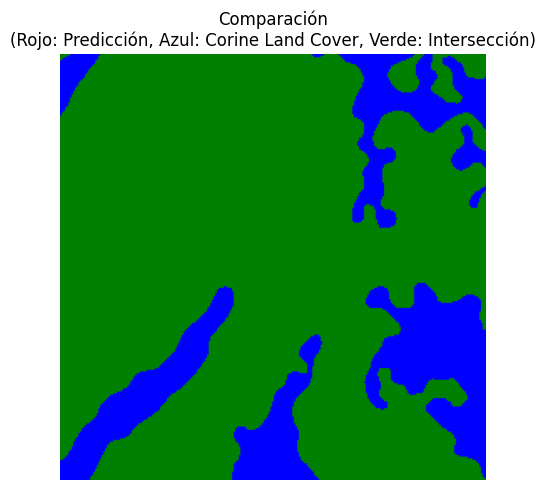


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 80.17%
   • DICE Coefficient:              89.00%
   • Pixel Accuracy:                80.17%
   • F1-Score:                      89.00%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     80.17%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           52133
   • False Positives (FP):          12892
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_13_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_13_agricola_raster_auto.tif

🔄 Procesando tile 14 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, cano

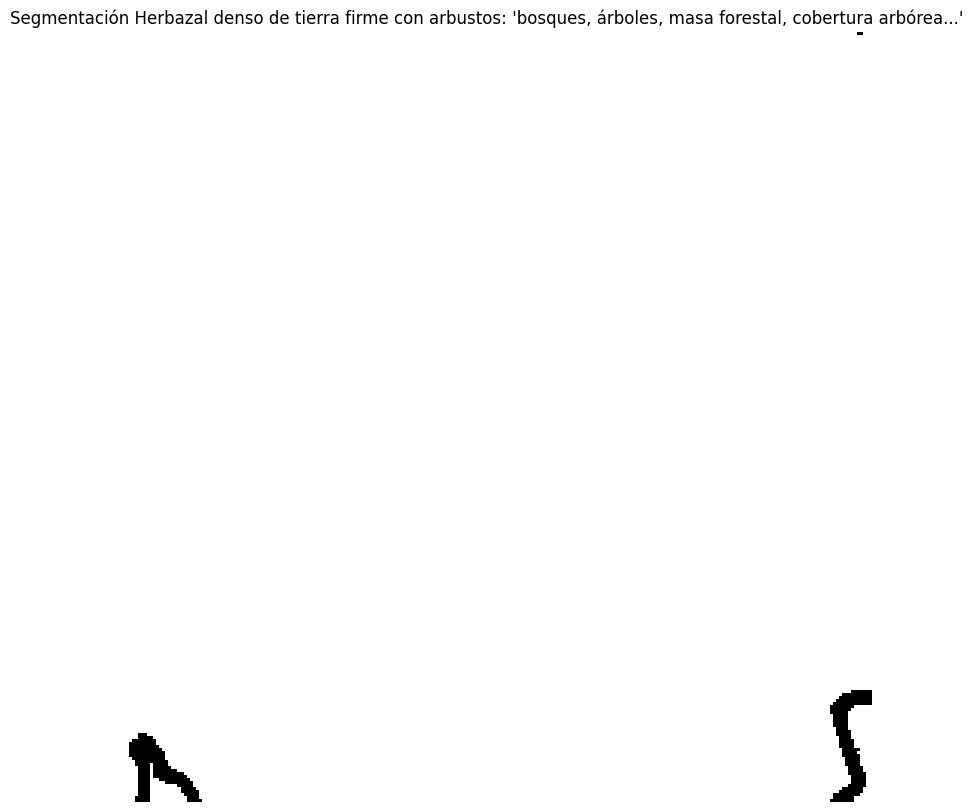

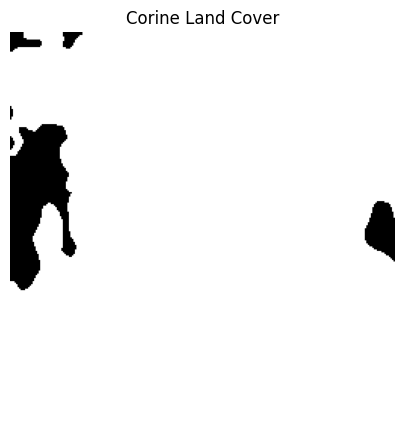

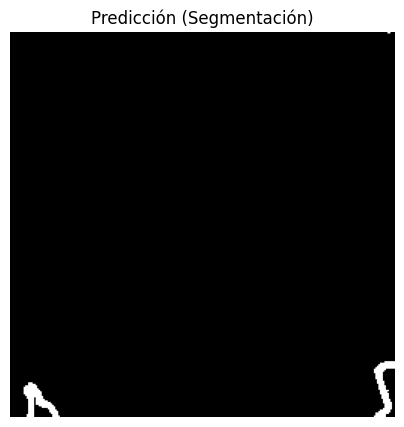

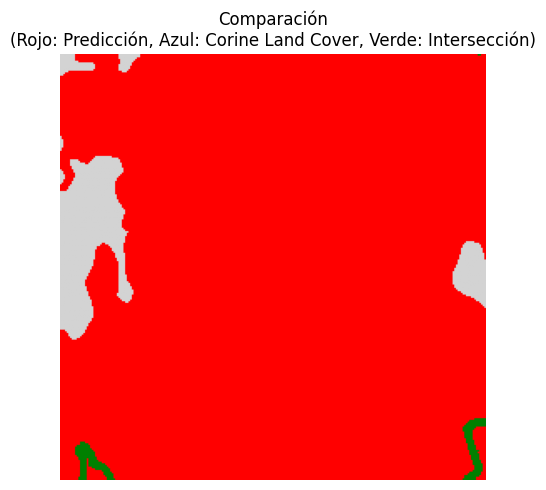


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.77%
   • DICE Coefficient:              1.53%
   • Pixel Accuracy:                6.57%
   • F1-Score:                      1.53%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.77%
   • FPR (False Positive Rate):     0.00%
   • Precision:                     100.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           473
   • False Positives (FP):          0
   • True Negatives (TN):           3799
   • False Negatives (FN):          60753
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_14_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_14_bosques_raster_auto.tif

🔄 Procesando tile 15 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Tile

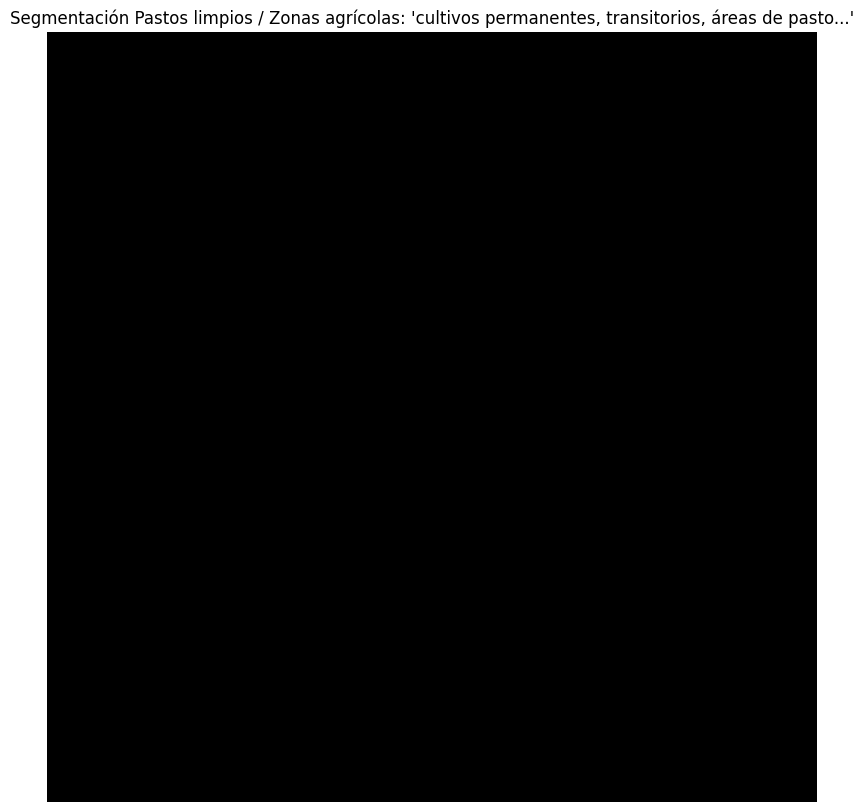

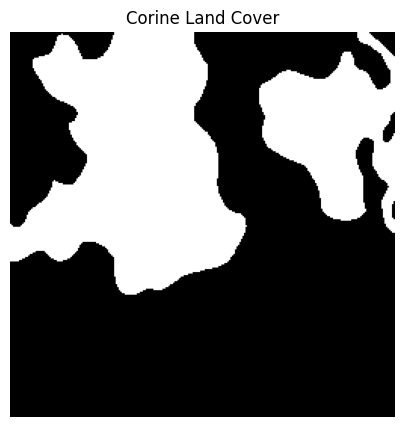

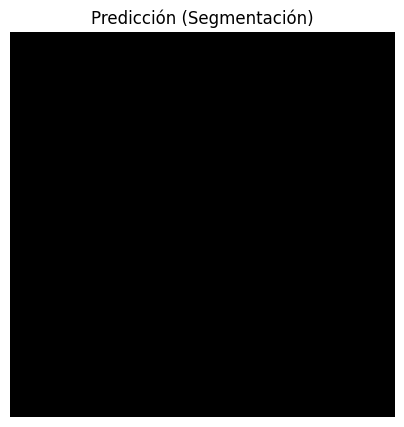

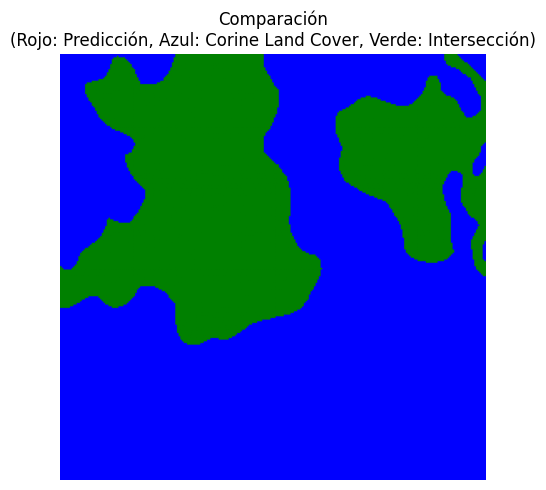


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 35.87%
   • DICE Coefficient:              52.80%
   • Pixel Accuracy:                35.87%
   • F1-Score:                      52.80%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     35.87%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           23326
   • False Positives (FP):          41699
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_15_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_15_agricola_raster_auto.tif

🔄 Procesando tile 16 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
 

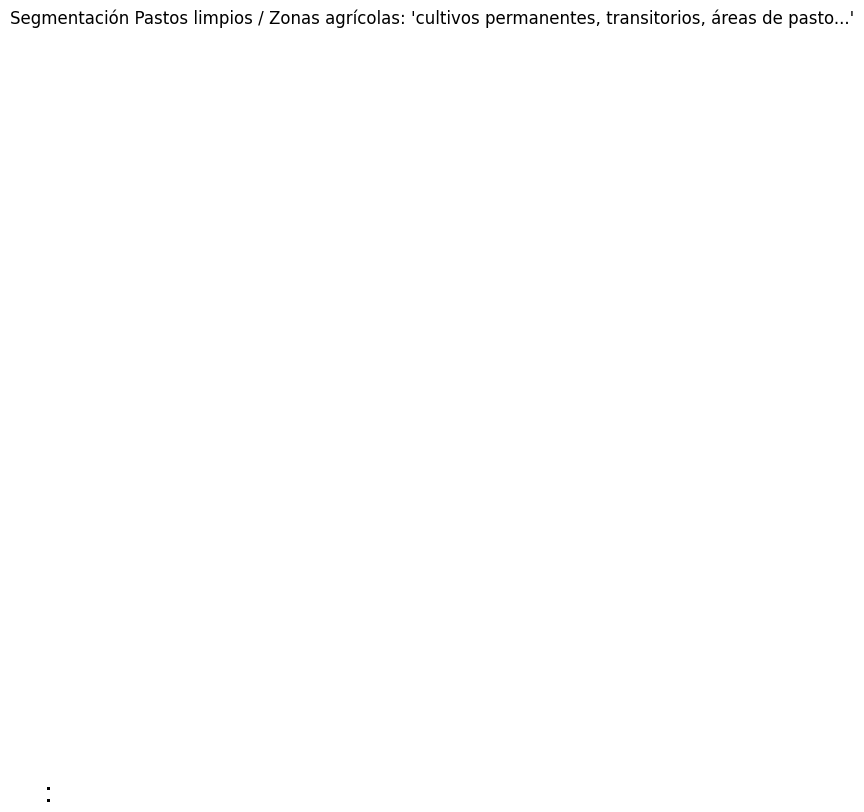

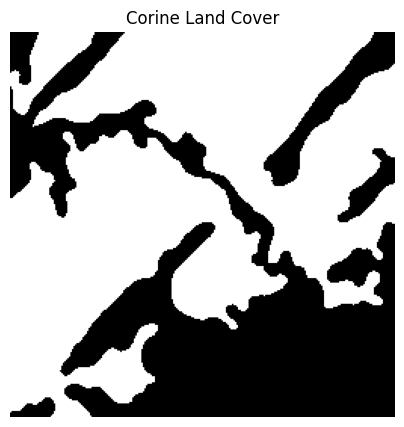

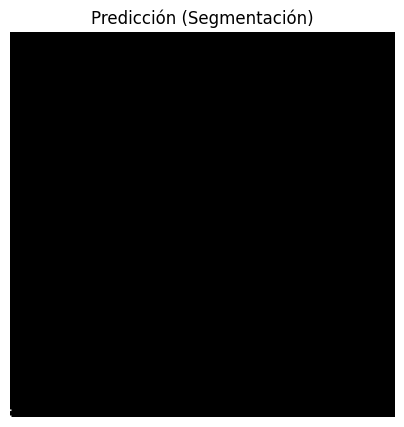

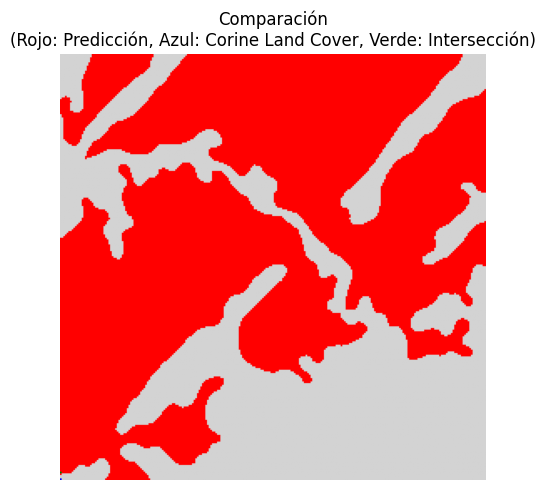


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.00%
   • DICE Coefficient:              0.01%
   • Pixel Accuracy:                39.12%
   • F1-Score:                      0.01%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.00%
   • FPR (False Positive Rate):     0.00%
   • Precision:                     50.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           1
   • False Positives (FP):          1
   • True Negatives (TN):           25436
   • False Negatives (FN):          39587
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_16_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_16_agricola_raster_auto.tif

🔄 Procesando tile 17 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Til

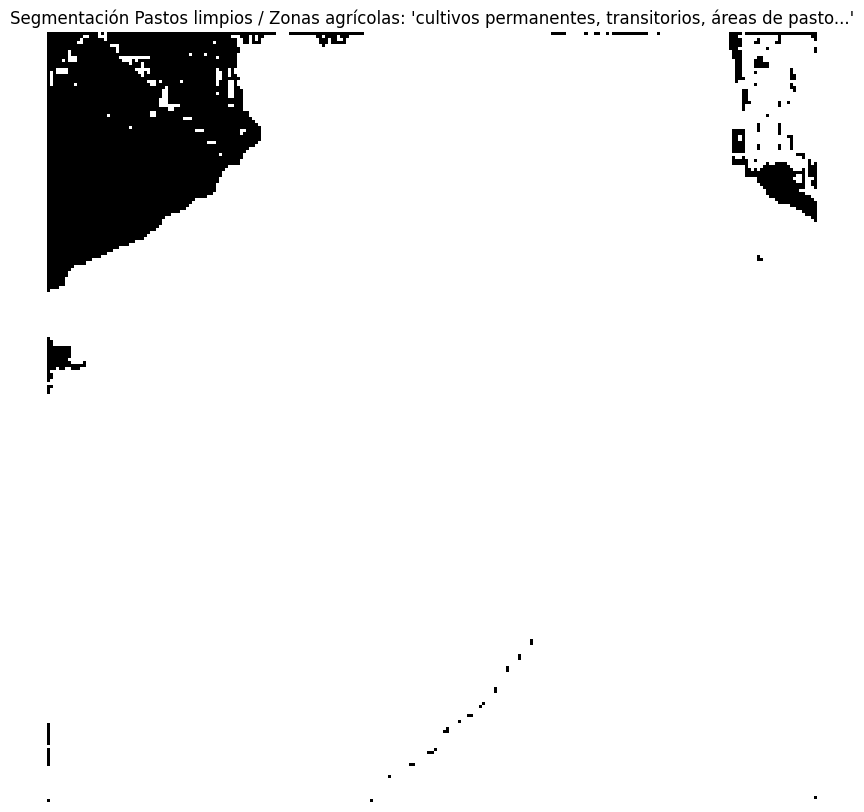

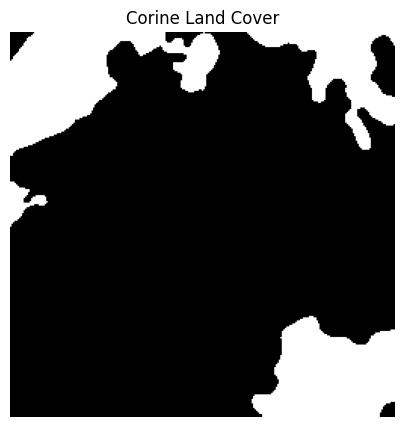

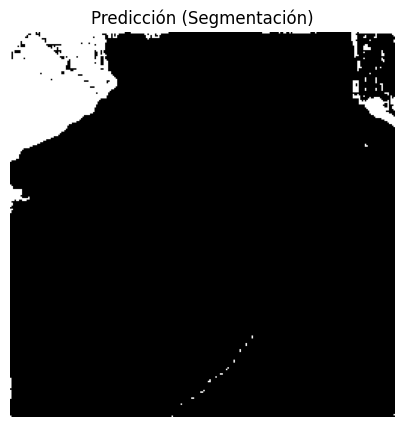

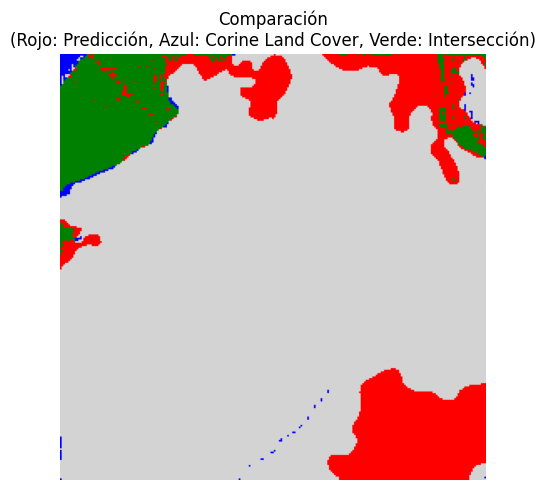


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 34.01%
   • DICE Coefficient:              50.76%
   • Pixel Accuracy:                86.61%
   • F1-Score:                      50.76%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    34.82%
   • FPR (False Positive Rate):     0.59%
   • Precision:                     93.56%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           4487
   • False Positives (FP):          309
   • True Negatives (TN):           51831
   • False Negatives (FN):          8398
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_17_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_17_agricola_raster_auto.tif

🔄 Procesando tile 18 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, can

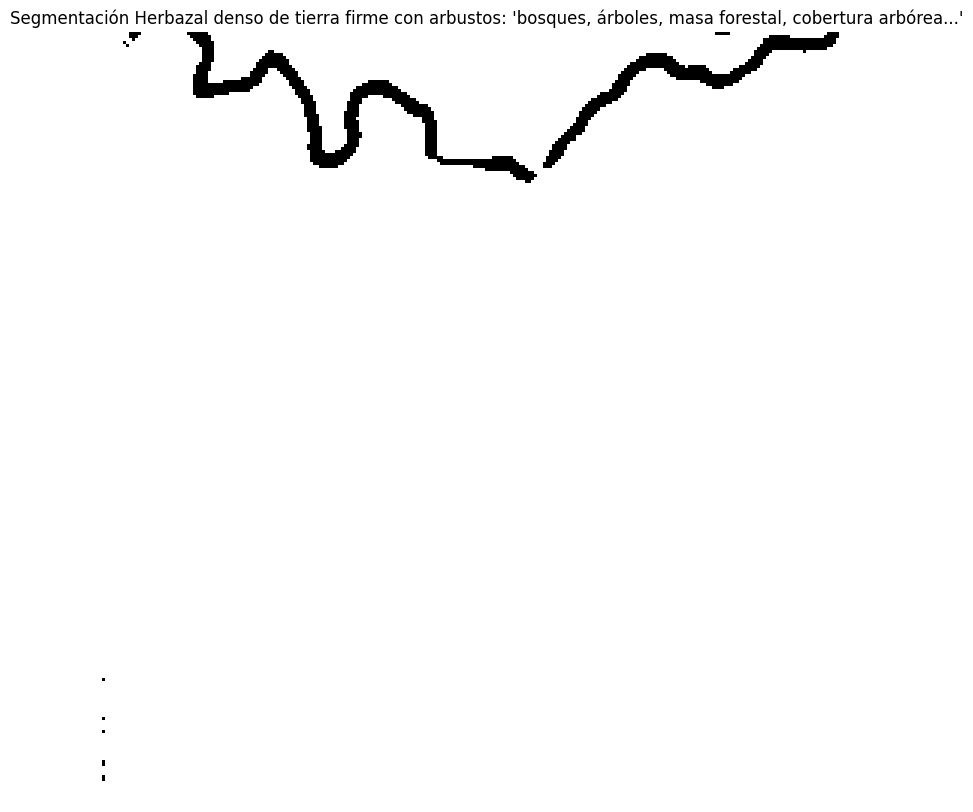

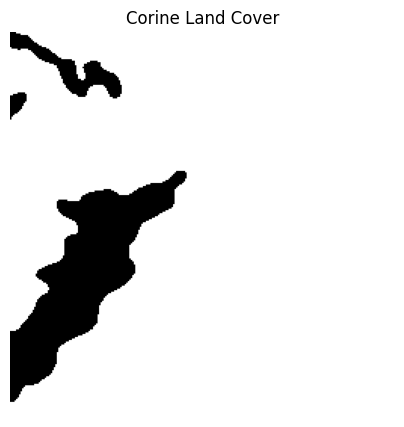

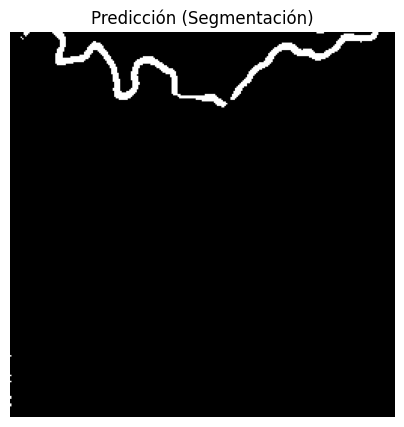

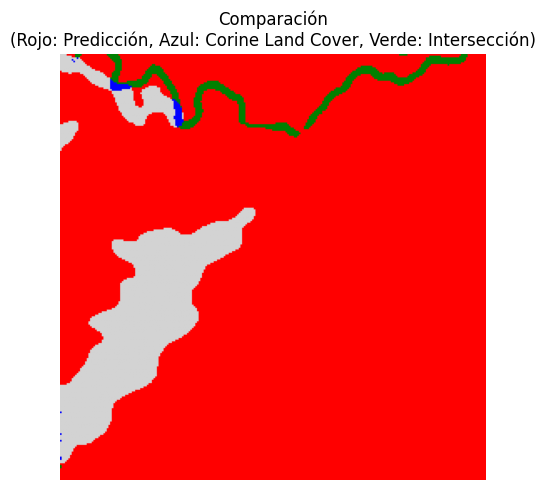


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 2.15%
   • DICE Coefficient:              4.21%
   • Pixel Accuracy:                12.89%
   • F1-Score:                      4.21%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    2.15%
   • FPR (False Positive Rate):     1.68%
   • Precision:                     91.07%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           1244
   • False Positives (FP):          122
   • True Negatives (TN):           7138
   • False Negatives (FN):          56521
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_18_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_18_bosques_raster_auto.tif

🔄 Procesando tile 19 -> tipo 'bosques' (codigo 321113)
PARÁMETROS:
   • Tipo de cobertura: bosques
   • Descripción: Herbazal denso de tierra firme con arbustos
   • Código CORINE: 321113
   • Prompt: 'bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia f

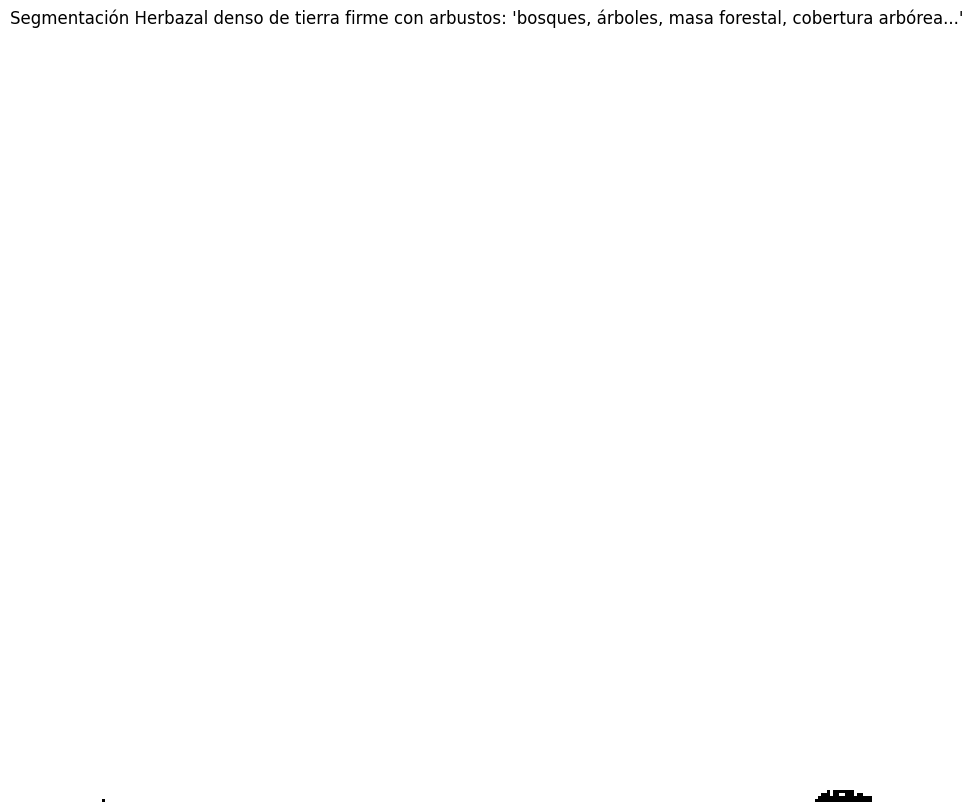

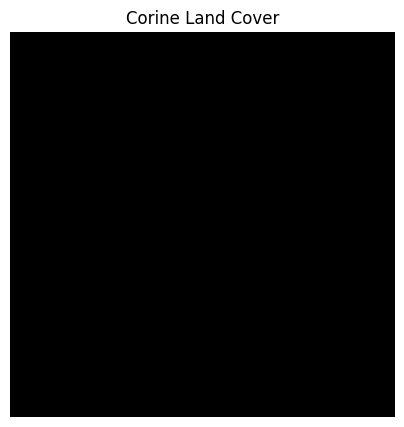

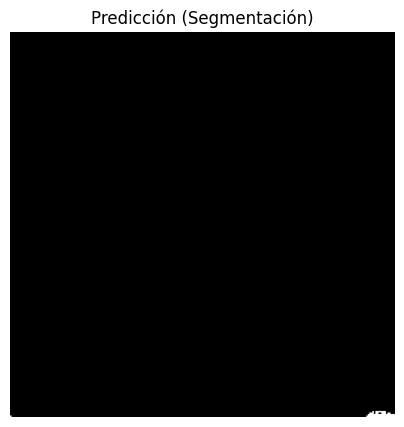

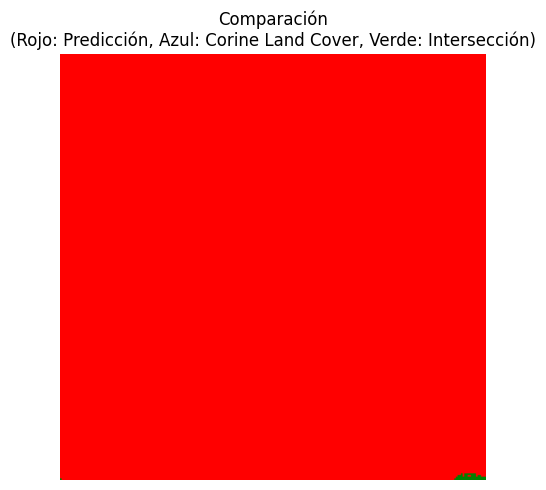


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.09%
   • DICE Coefficient:              0.17%
   • Pixel Accuracy:                0.09%
   • F1-Score:                      0.17%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    0.09%
   • FPR (False Positive Rate):     0.00%
   • Precision:                     100.00%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           56
   • False Positives (FP):          0
   • True Negatives (TN):           0
   • False Negatives (FN):          64969
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_19_bosques_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_19_bosques_raster_auto.tif

🔄 Procesando tile 20 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   • Tile: 20

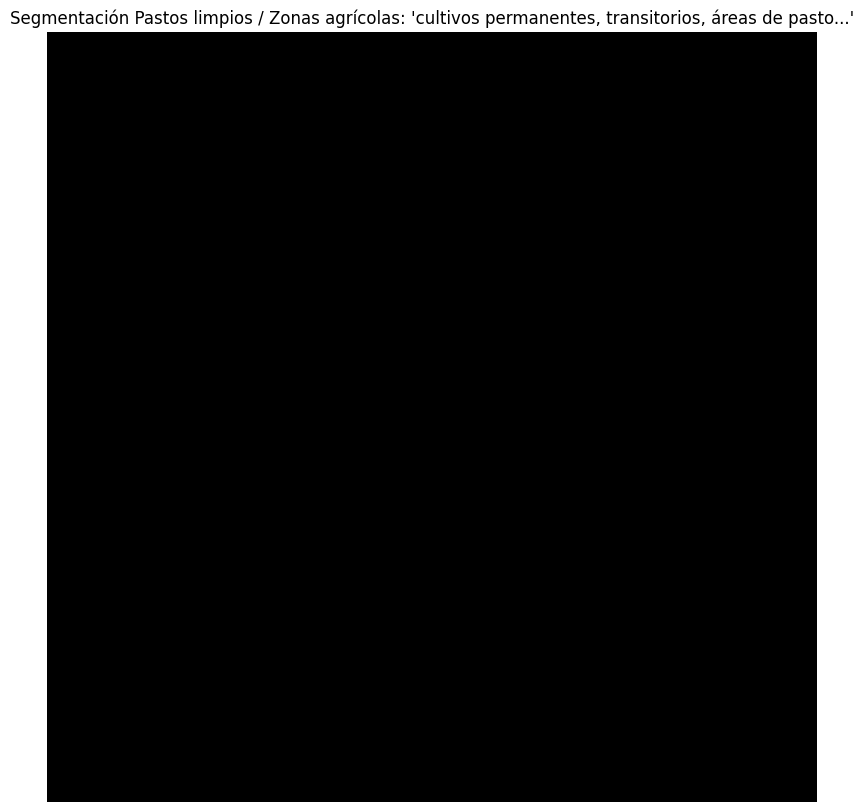

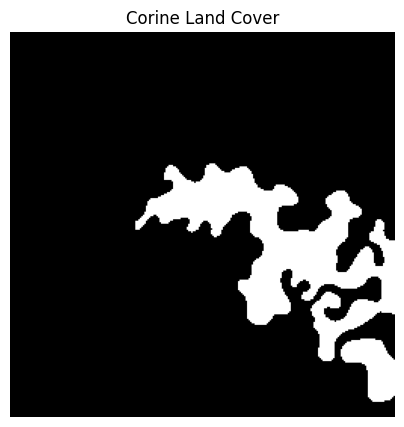

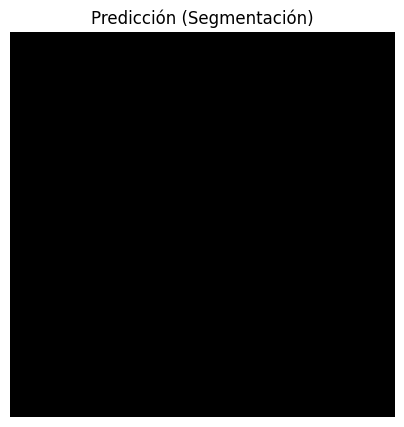

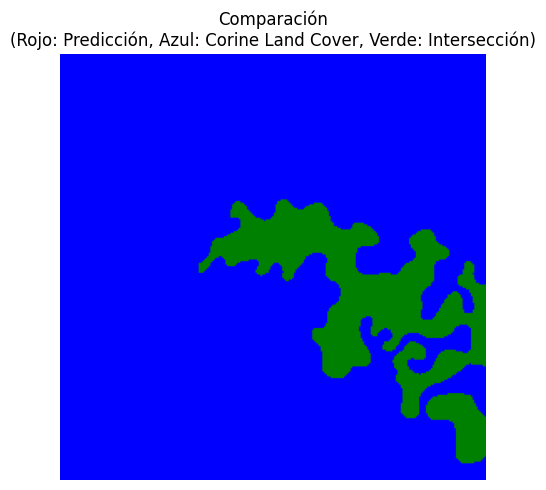


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 13.49%
   • DICE Coefficient:              23.77%
   • Pixel Accuracy:                13.49%
   • F1-Score:                      23.77%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     100.00%
   • Precision:                     13.49%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           8771
   • False Positives (FP):          56254
   • True Negatives (TN):           0
   • False Negatives (FN):          0
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_20_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_20_agricola_raster_auto.tif

🔄 Procesando tile 21 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
  

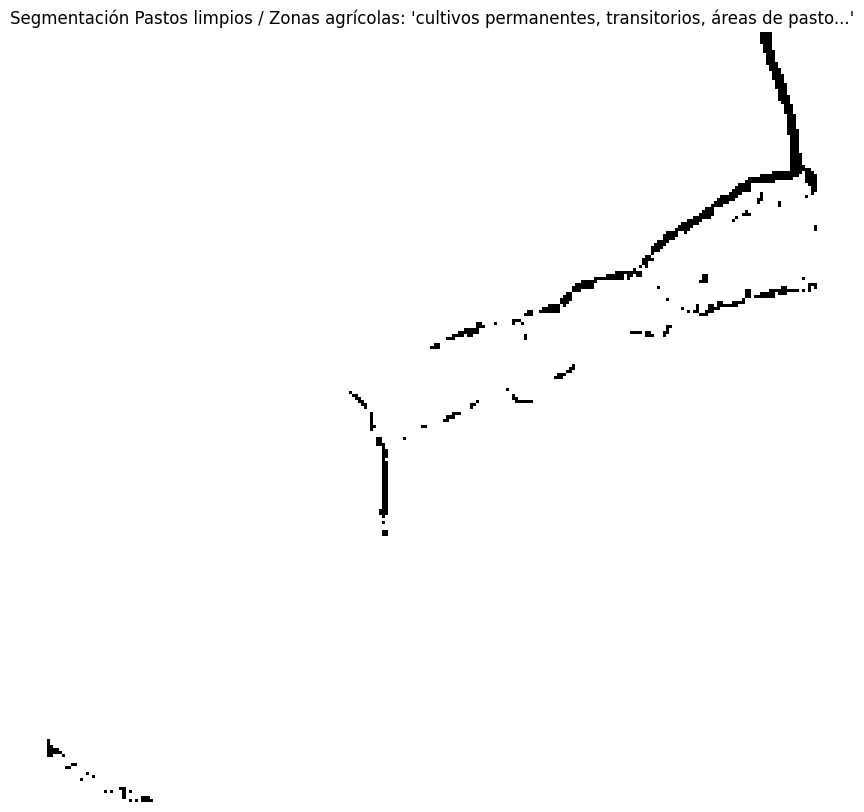

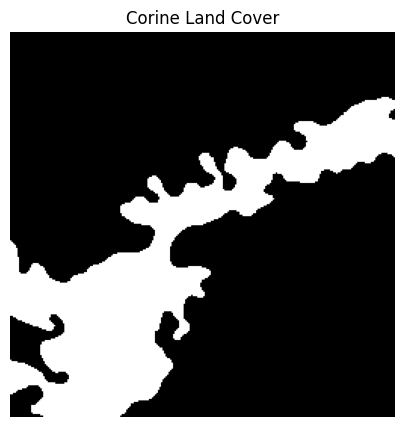

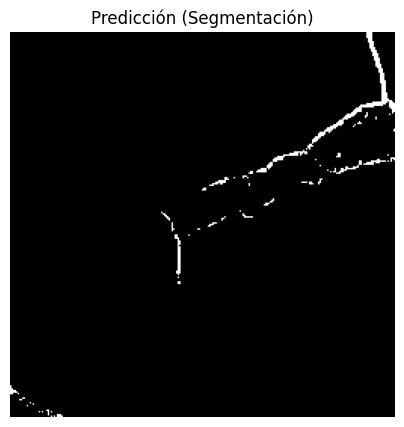

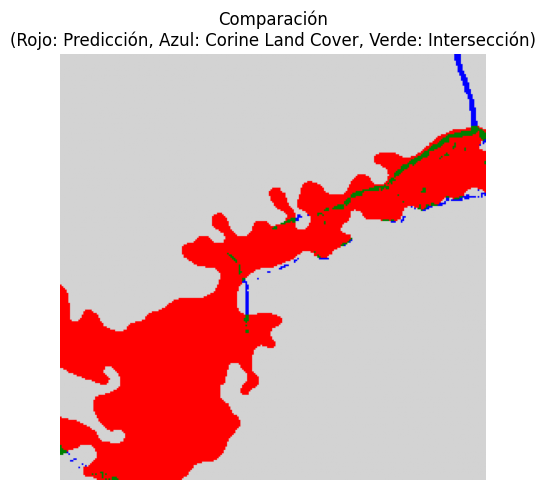


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 2.86%
   • DICE Coefficient:              5.55%
   • Pixel Accuracy:                76.52%
   • F1-Score:                      5.55%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    2.91%
   • FPR (False Positive Rate):     0.59%
   • Precision:                     60.35%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           449
   • False Positives (FP):          295
   • True Negatives (TN):           49308
   • False Negatives (FN):          14973
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_21_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_21_agricola_raster_auto.tif

🔄 Procesando tile 22 -> tipo 'agricola' (codigo 231)
PARÁMETROS:
   • Tipo de cobertura: agricola
   • Descripción: Pastos limpios / Zonas agrícolas
   • Código CORINE: 231
   • Prompt: 'cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas'
   •

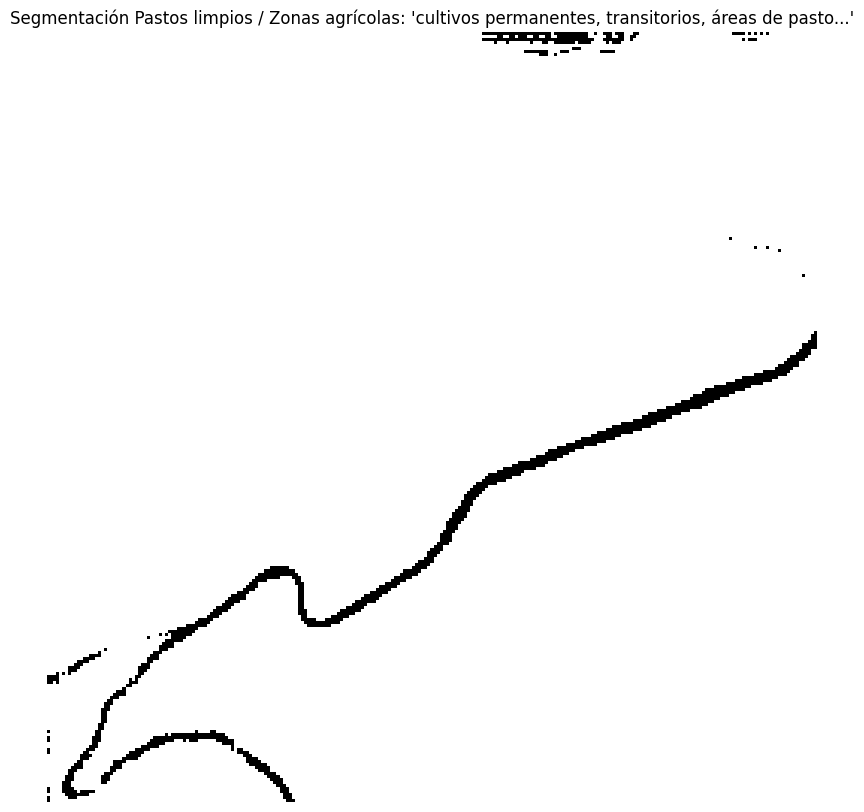

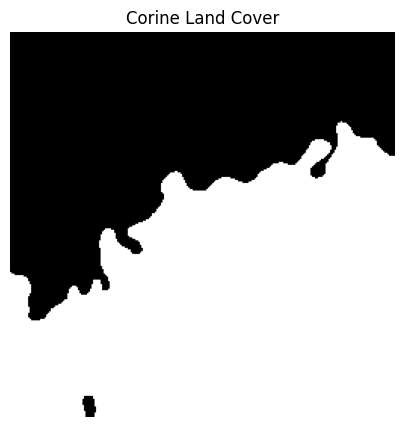

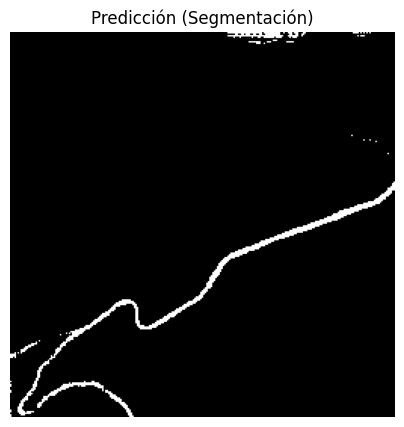

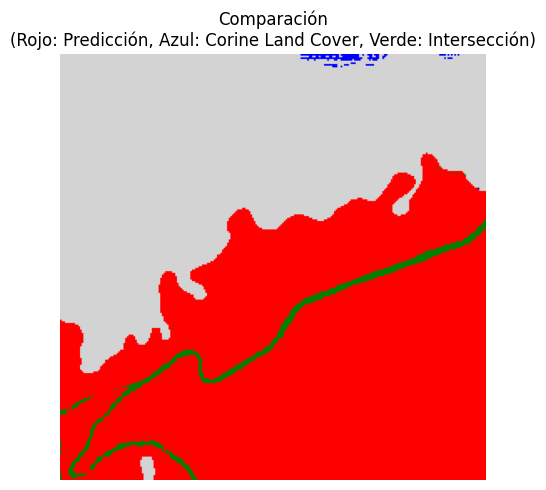


🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 3.58%
   • DICE Coefficient:              6.92%
   • Pixel Accuracy:                46.83%
   • F1-Score:                      6.92%

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    3.60%
   • FPR (False Positive Rate):     0.58%
   • Precision:                     88.26%

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           1285
   • False Positives (FP):          171
   • True Negatives (TN):           29168
   • False Negatives (FN):          34401
\Archivos generados:
Segmentación: ../tiles/segmentation_text/Guatavita_22_agricola_auto.tif
Ground Truth: ../tiles/LandUseRaster/Guatavita_22_agricola_raster_auto.tif

✅ Procesamiento finalizado. Resumen:
tile_0 -> agua  IoU: 0.7924047459893048
tile_1 -> agua  IoU: 0.48286043829296427
tile_2 -> agua  IoU: 0.4928310470807197
tile_3 -> agricola  IoU: 0.21262826586160938
tile_4 -> urbano  IoU: 0.0
tile_5 -> agricola  IoU: 0.8460130718954249
tile

In [18]:
# 📋 DICCIONARIO DE PROMPTS Y CÓDIGOS CORINE
PROMPTS_CORINE = {
    "agua": {
        "prompt": "agua, cuerpo de agua, lago, embalse, superficie de agua, laguna",
        "codigo": 512,
        "descripcion": "Cuerpos de agua",
    },
    "urbano": {
        "prompt": "construction",
        "codigo": 111,
        "descripcion": "Tejido urbano continuo",
    },
    "agricola": {
        "prompt": "cultivos permanentes, transitorios, áreas de pastos y las zonas agrícolas heterogéneas",
        "codigo": 231,
        "descripcion": "Pastos limpios / Zonas agrícolas",
    },
    "bosques": {
        "prompt": "bosques, árboles, masa forestal, cobertura arbórea, vegetación densa, canopia forestal, plantaciones forestales",
        "codigo": 321113,
        "descripcion": "Herbazal denso de tierra firme con arbustos",
    }
}

SUGGESTED_PARAMS = {
    "agua": {
        "box_threshold": 0.45,      # áreas amplias y homogéneas -> más confianza en cajas
        "text_threshold": 0.85,     # exigir fuerte coincidencia textual
        "multimask_output": False,
        "min_area_px": 5000,        # eliminar pequeños falsos positivos
        "morph_close": 5
    },
    "urbano": {
        "box_threshold": 0.10,      # fragmentado -> aceptar cajas menos confiables
        "text_threshold": 0.65,     # texto más laxo
        "multimask_output": True,    # puede ayudar a capturar múltiples objetos pequeños
        "min_area_px": 100,         # conservar pequeños parches urbanos
        "morph_close": 3
    },
    "agricola": {
        "box_threshold": 0.40,
        "text_threshold": 0.80,
        "multimask_output": True,
        "min_area_px": 1000,
        "morph_close": 5
    },
    "bosques": {
        "box_threshold": 0.30,
        "text_threshold": 0.85,
        "multimask_output": False,
        "min_area_px": 2000,
        "morph_close": 7
    }
}

def segment_and_evaluate_auto(tipo_cobertura, tile_number=0):
    """
    Función automatizada para segmentar diferentes tipos de cobertura y evaluar métricas
    
    Args:
        tipo_cobertura (str): Tipo de cobertura ("agua", "urbano", "agricola", "bosques")
        tile_number (int): Número del tile a procesar (default: 0)
        box_threshold (float): Umbral para detección de cajas (default: 0.45)
        text_threshold (float): Umbral para coincidencia de texto (default: 0.9)
    
    Returns:
        dict: Métricas de evaluación calculadas
    """
    import os
    
    # Verificar que el tipo de cobertura existe
    if tipo_cobertura not in PROMPTS_CORINE:
        print(f"❌ Error: Tipo de cobertura '{tipo_cobertura}' no válido.")
        print(f"📋 Opciones disponibles: {list(PROMPTS_CORINE.keys())}")
        return None
    
    # Obtener prompt y código del diccionario
    cobertura_info = PROMPTS_CORINE[tipo_cobertura]
    prompt = cobertura_info["prompt"]
    codigo_filtro = cobertura_info["codigo"]
    descripcion = cobertura_info["descripcion"]
    
    # Generar nombres de archivos automáticamente
    base_name = f"Guatavita_{tile_number}"
    
    # Rutas de archivos de entrada
    sentinel_path = f'../tiles/Sentinel/{base_name}_crop.tif'
    geojson_path = f'../tiles/LandUse/{base_name}_crop.geojson'
    
    # Rutas de archivos de salida (se generan automáticamente)
    segmentation_output = f'../tiles/segmentation_text/{base_name}_{tipo_cobertura}_auto.tif'
    landuse_raster_output = f'../tiles/LandUseRaster/{base_name}_{tipo_cobertura}_raster_auto.tif'
    
    # Crear directorios si no existen
    os.makedirs('../tiles/segmentation_text', exist_ok=True)
    os.makedirs('../tiles/LandUseRaster', exist_ok=True)
    
    print(f"PARÁMETROS:")
    print(f"   • Tipo de cobertura: {tipo_cobertura}")
    print(f"   • Descripción: {descripcion}")
    print(f"   • Código CORINE: {codigo_filtro}")
    print(f"   • Prompt: '{prompt}'")
    print(f"   • Tile: {tile_number}")
    
    # Verificar que existan los archivos de entrada
    if not os.path.exists(sentinel_path):
        print(f"❌ Error: No se encuentra {sentinel_path}")
        return None
    
    if not os.path.exists(geojson_path):
        print(f"❌ Error: No se encuentra {geojson_path}")
        return None

    print(f"PASO 1: SEGMENTACIÓN CON SAM")
    print(f"   • Entrada: {sentinel_path}")
    print(f"   • Salida: {segmentation_output}")
    params = SUGGESTED_PARAMS[tipo_cobertura]
    # Segmentación con SAM
    sam.predict(sentinel_path, prompt,
             box_threshold=params["box_threshold"],
             text_threshold=params["text_threshold"],
             multimask_output=params["multimask_output"])
    sam.show_anns(
        cmap="Greys_r",
        add_boxes=False,
        alpha=1,
        title=f"Segmentación {descripcion}: '{prompt[:50]}...'",
        blend=False,
        output=segmentation_output,
    )
    
    print(f"Segmentación completada")

    print(f"PASO 2: CONVERSIÓN GEOJSON A RASTER")
    print(f"   • Entrada: {geojson_path}")
    print(f"   • Código filtro: {codigo_filtro}")
    print(f"   • Salida: {landuse_raster_output}")
    
    # Convertir GeoJSON a raster
    raster = geojson_to_raster(
        geojson_path=geojson_path,
        reference_tif_path=sentinel_path,
        output_path=landuse_raster_output,
        codigo_filtro=codigo_filtro
    )

    print(f"PASO 3: CÁLCULO DE MÉTRICAS")

    # Función de cálculo de métricas integrada
    def calculate_metrics_auto(mask_path, land_path, target_value=0):
        with rasterio.open(mask_path) as src1:
            raster1 = src1.read(1)
        
        with rasterio.open(land_path) as src2:
            raster2 = src2.read(1)

        mask1 = (raster1 == target_value).astype(int)
        mask2 = (raster2 == target_value).astype(int)
        
        intersection = np.sum(mask1 & mask2)
        union = np.sum(mask1 | mask2)
        sum_masks = np.sum(mask1) + np.sum(mask2)

        FP = np.sum(mask2) - intersection
        FN = np.sum(mask1) - intersection
        TN = mask1.size - intersection - FP - FN

        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
            dice = 1.0 if sum_masks == 0 else 0.0
        else:
            iou = intersection / union
            dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

        pixel_accuracy = (intersection + TN) / mask1.size
        tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        precision = intersection / (intersection + FP) if (intersection + FP) > 0 else 0.0
        f1_score = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0.0

        # Visualización
        comparison = np.zeros_like(mask1)
        comparison[mask1 == 1] = 1
        comparison[mask2 == 1] = 2
        comparison[(mask1 == 1) & (mask2 == 1)] = 3
        
        
        # Visualizar
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
        fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

        axes.imshow(mask1, cmap='gray')
        axes.set_title('Corine Land Cover')
        axes.axis('off')

        axes1.imshow(mask2, cmap='gray')
        axes1.set_title('Predicción (Segmentación)')
        axes1.axis('off')
        
        # Colores personalizados para la comparación
        colors = ['lightgray', 'red', 'blue', 'green']
        cmap = plt.matplotlib.colors.ListedColormap(colors)

        im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
        axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
        axes2.axis('off')

        plt.tight_layout()
        plt.show()
        
        results = {
            'IoU': iou,
            'DICE': dice,
            'Pixel_Accuracy': pixel_accuracy,
            'TPR_Sensitivity_Recall': tpr,
            'FPR': fpr,
            'Precision': precision,
            'F1_Score': f1_score,
            'TP': intersection,
            'FP': FP,
            'TN': TN,
            'FN': FN
        }
        
        return results
    
    # Calcular métricas
    results = calculate_metrics_auto(
        mask_path=landuse_raster_output,
        land_path=segmentation_output,
        target_value=0
    )

    print_metrics_percent(results)
    print(f"\Archivos generados:")
    print(f"Segmentación: {segmentation_output}")
    print(f"Ground Truth: {landuse_raster_output}")
    
    return results

pairs = [{0:512},{1:512},{2:512},{3:231},{4:111},{5:231},{6:231}, {7:321113},{8:321113}, {9:321113},{10:321113},{11:321113},{12:321113},{13:231},{14:321113},{15:231},{16:231},{17:231},{18:321113},{19:321113},{20:231},{21:231},{22:231} ]  # tu estructura original
# Normalizar a lista de tuplas (tile, codigo)
tiles_codes = []
for p in pairs:
    # p puede ser dict con un solo par
    if isinstance(p, dict):
        for k,v in p.items():
            try:
                tile = int(k)
            except Exception:
                tile = k
            tiles_codes.append((tile, int(v)))
    elif isinstance(p, (list, tuple)) and len(p) == 2:
        tiles_codes.append((int(p[0]), int(p[1])))
    else:
        print("Formato desconocido en:", p)

results_all = {}
for tile, code in tiles_codes:
    # Buscar tipo_cobertura en PROMPTS_CORINE por codigo
    tipo_found = None
    for tipo, info in PROMPTS_CORINE.items():
        if int(info.get("codigo", -1)) == int(code):
            tipo_found = tipo
            break

    if tipo_found is None:
        print(f"⚠️ No se encontró tipo CORINE para código {code} (tile {tile}), se salta.")
        continue

    print(f"\n🔄 Procesando tile {tile} -> tipo '{tipo_found}' (codigo {code})")
    try:
        res = segment_and_evaluate_auto(tipo_found, tile_number=tile)
        results_all[f"tile_{tile}"] = {"tipo": tipo_found, "codigo": code, "results": res}
    except Exception as e:
        print(f"❌ Error procesando tile {tile}: {e}")

print("\n✅ Procesamiento finalizado. Resumen:")
for k,v in results_all.items():
    print(k, "->", v["tipo"], " IoU:", None if v["results"] is None else v["results"].get("IoU"))
# ...existing code...